In [1]:
  from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [3]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098200,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,4
1098201,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,4
1098202,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,4
1098203,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,4


<Axes: xlabel='activity', ylabel='count'>

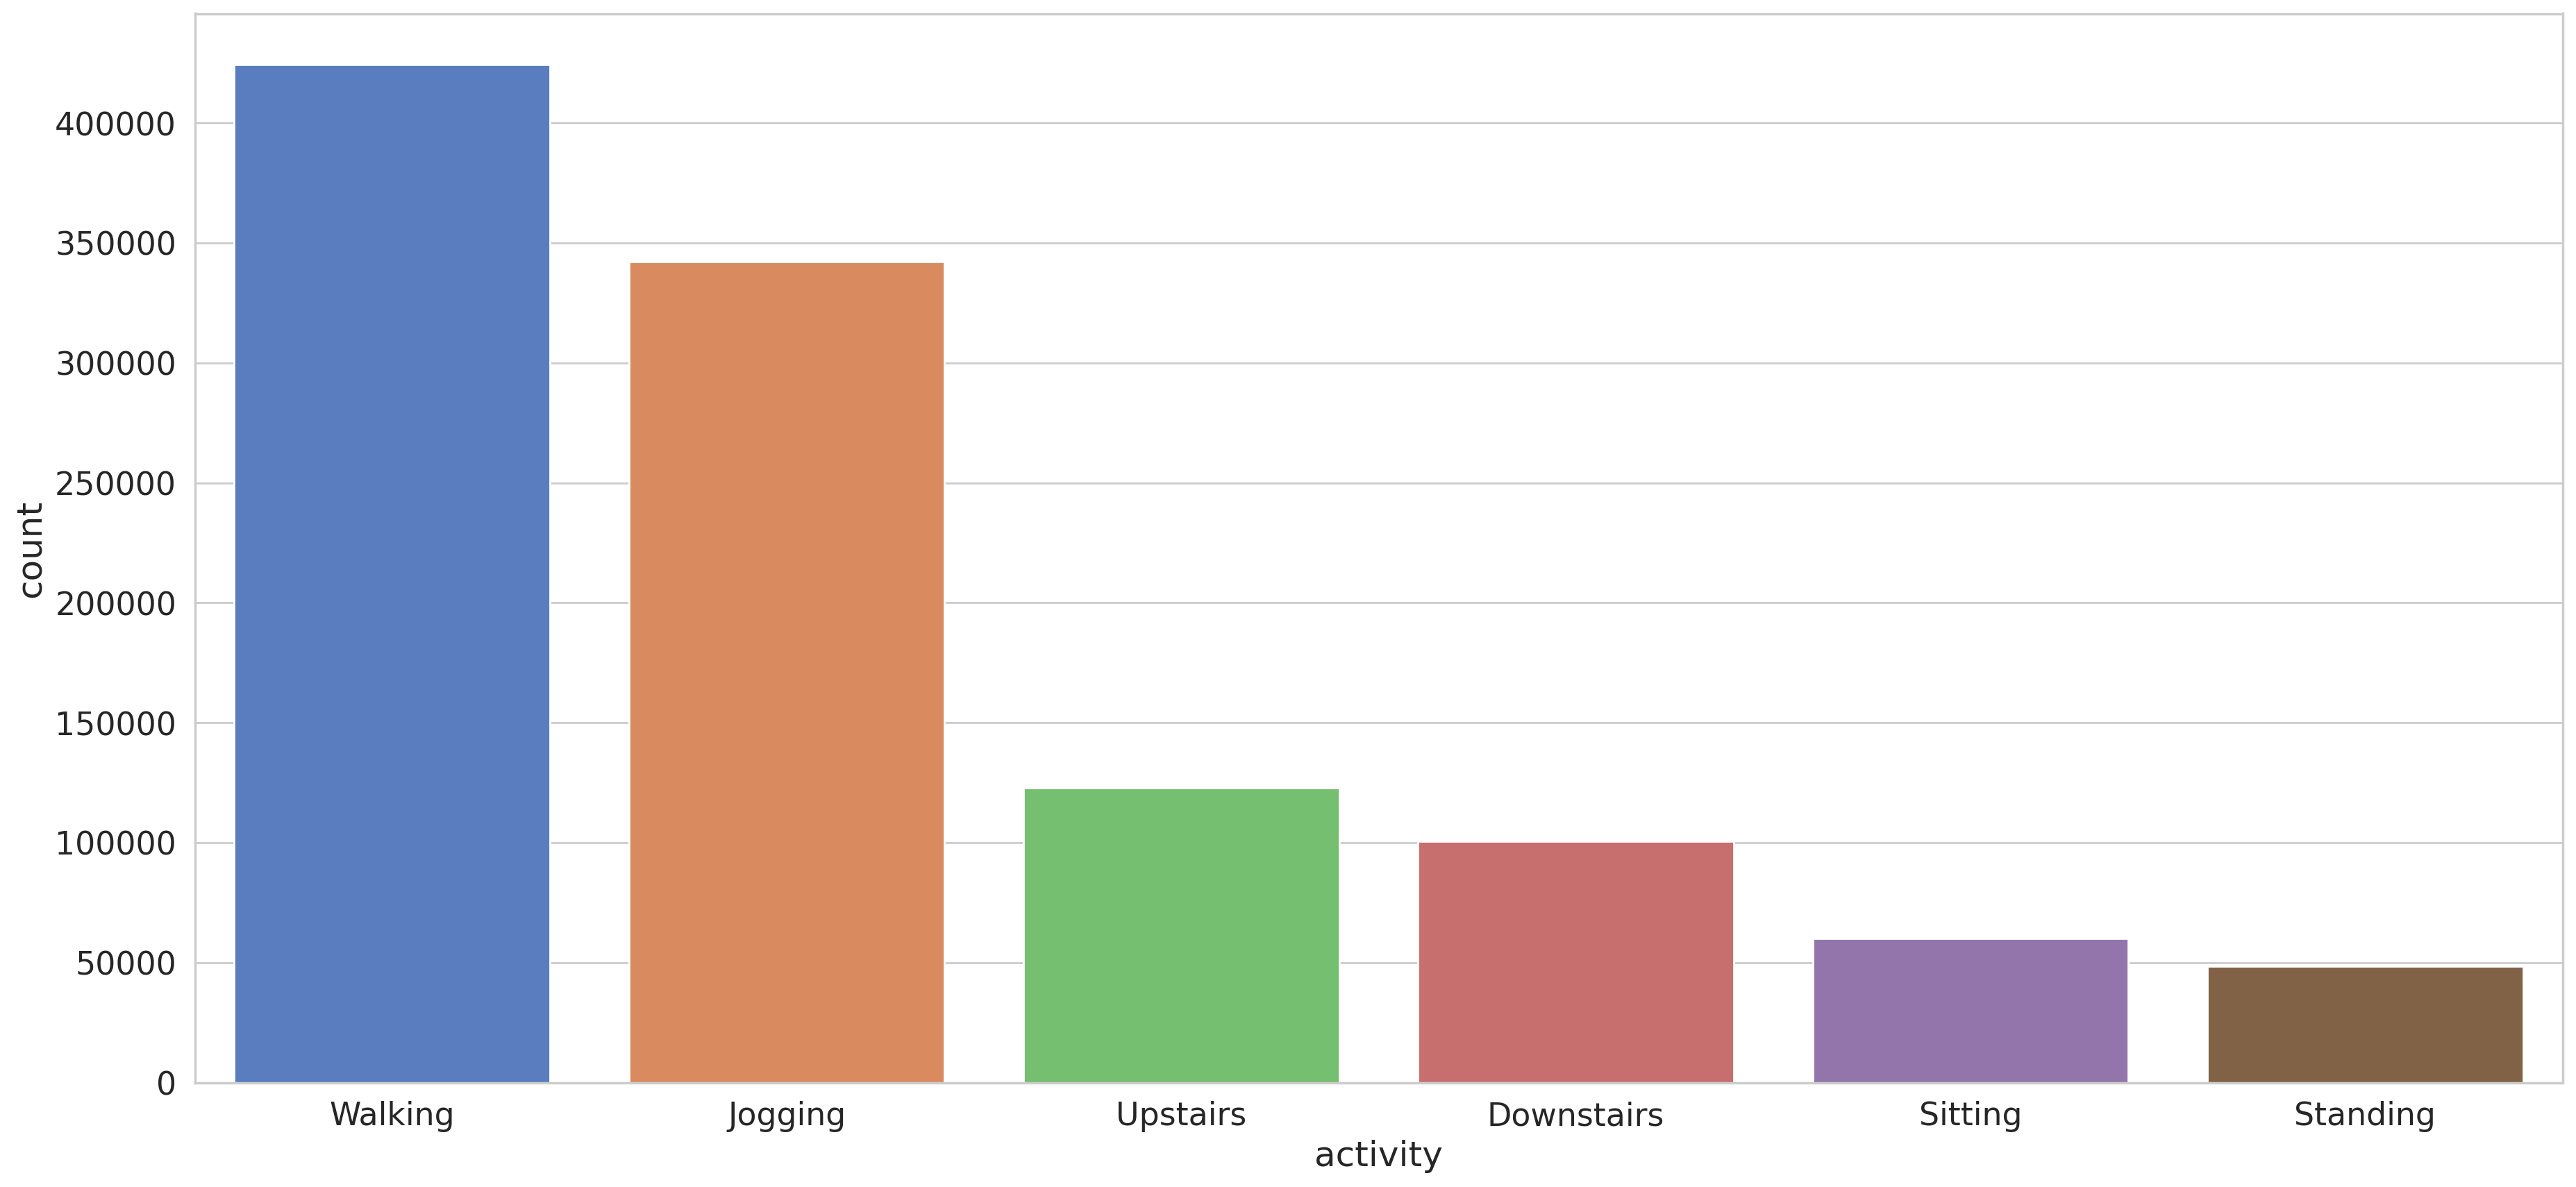

In [6]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

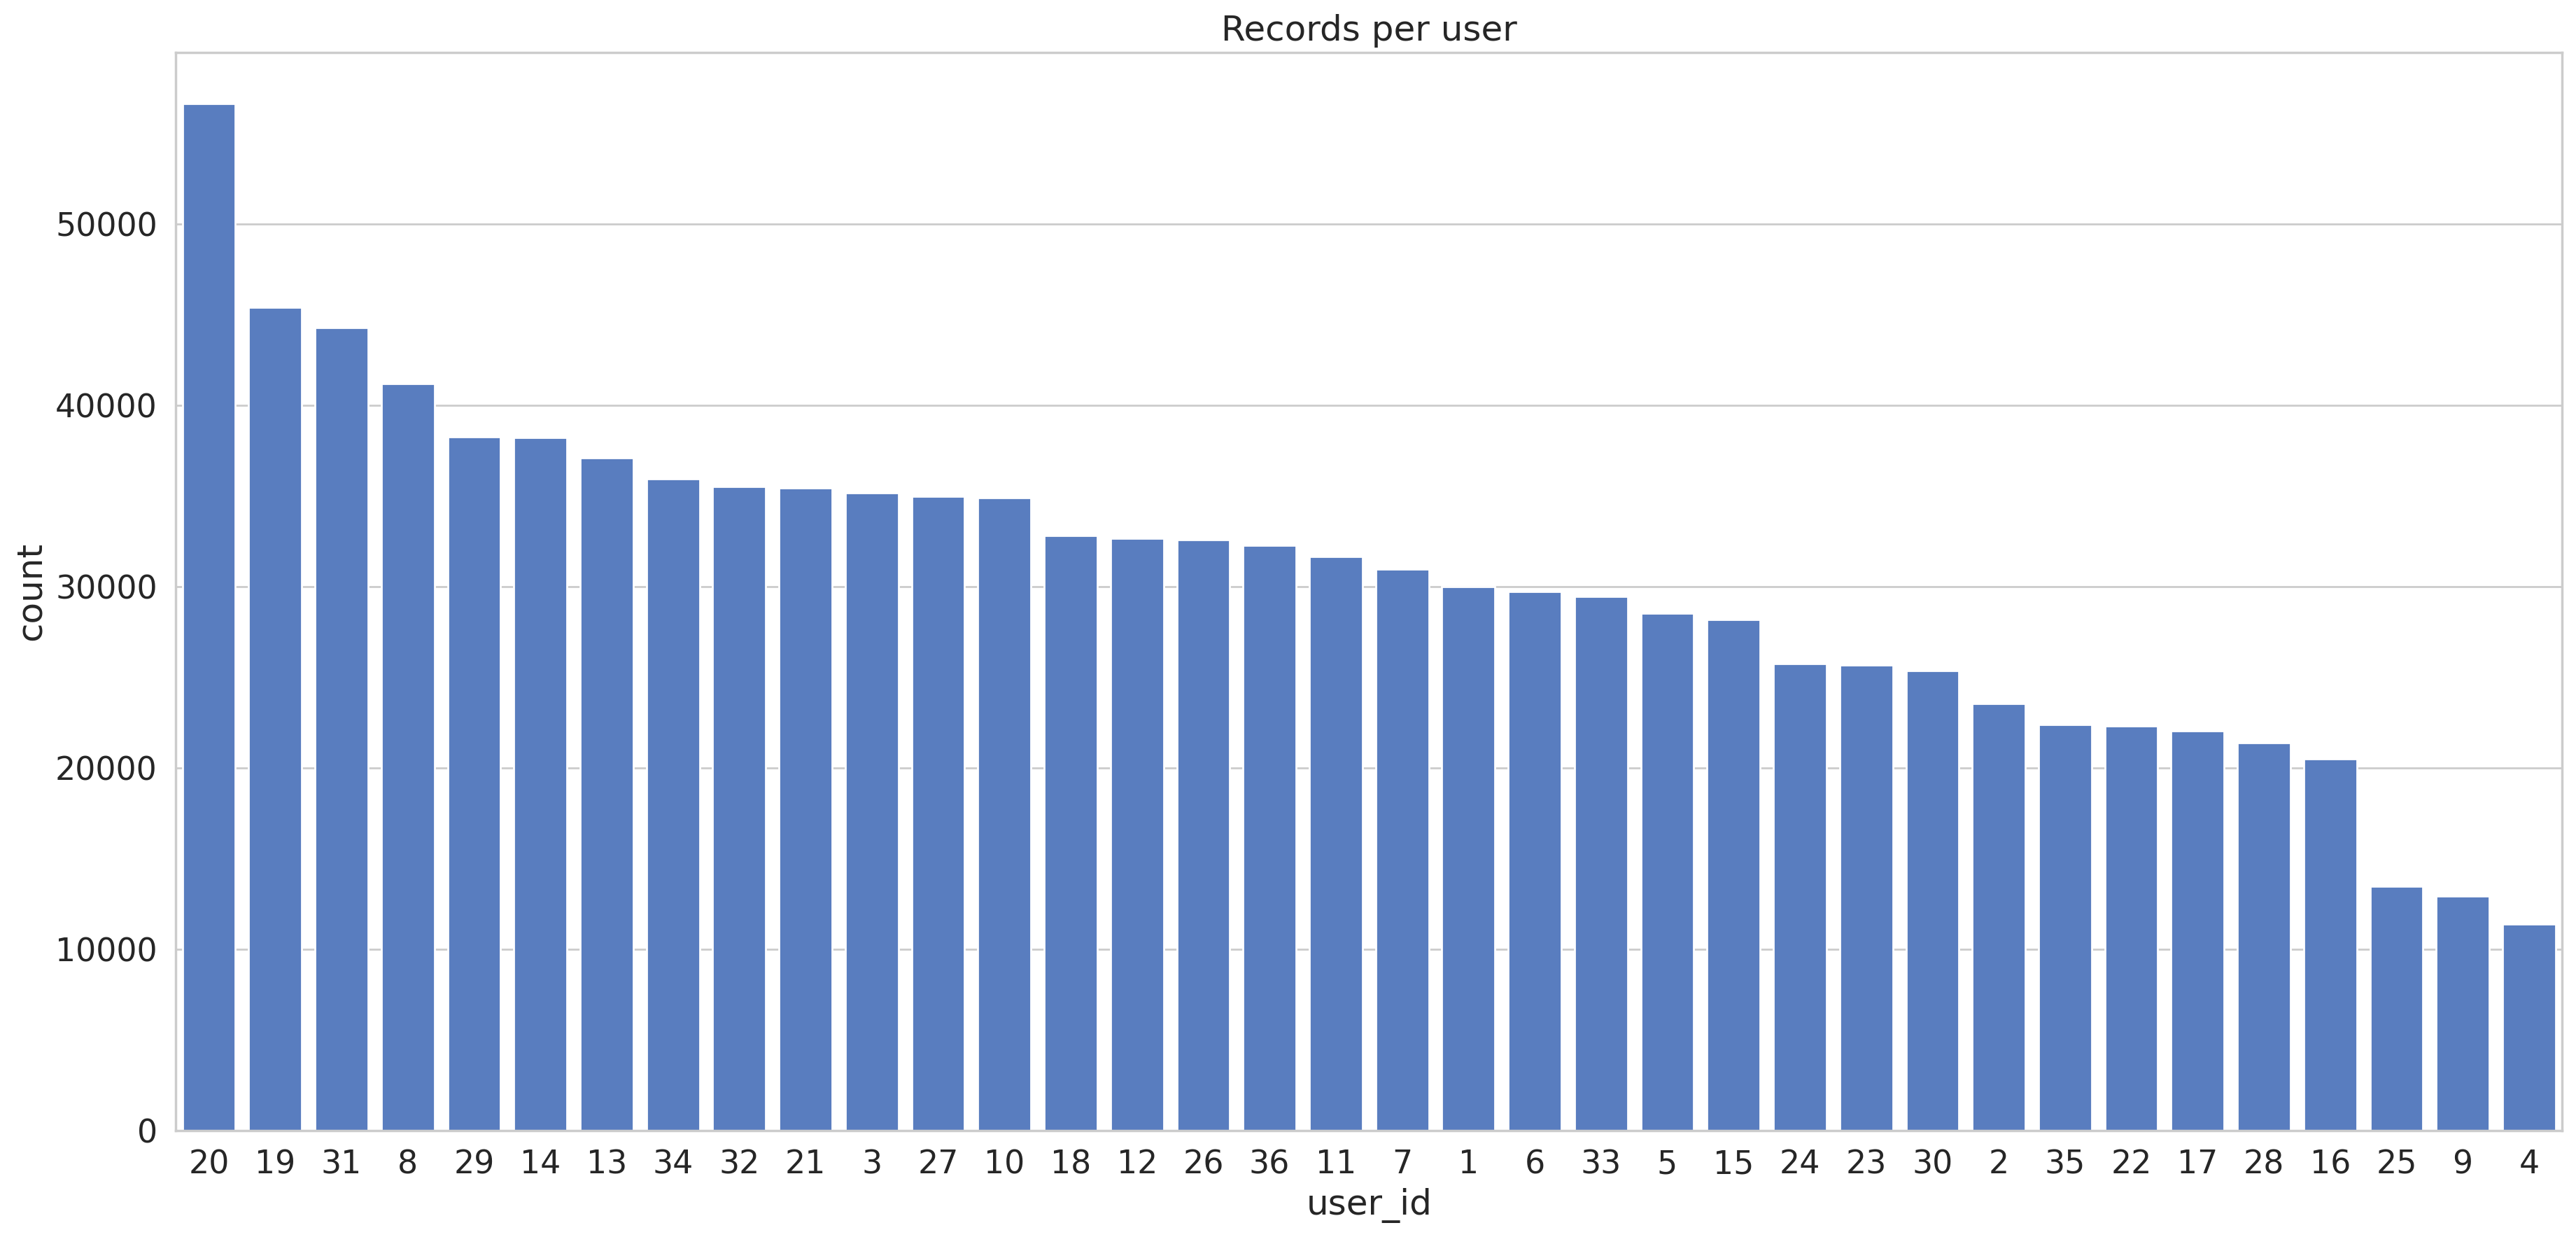

In [7]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


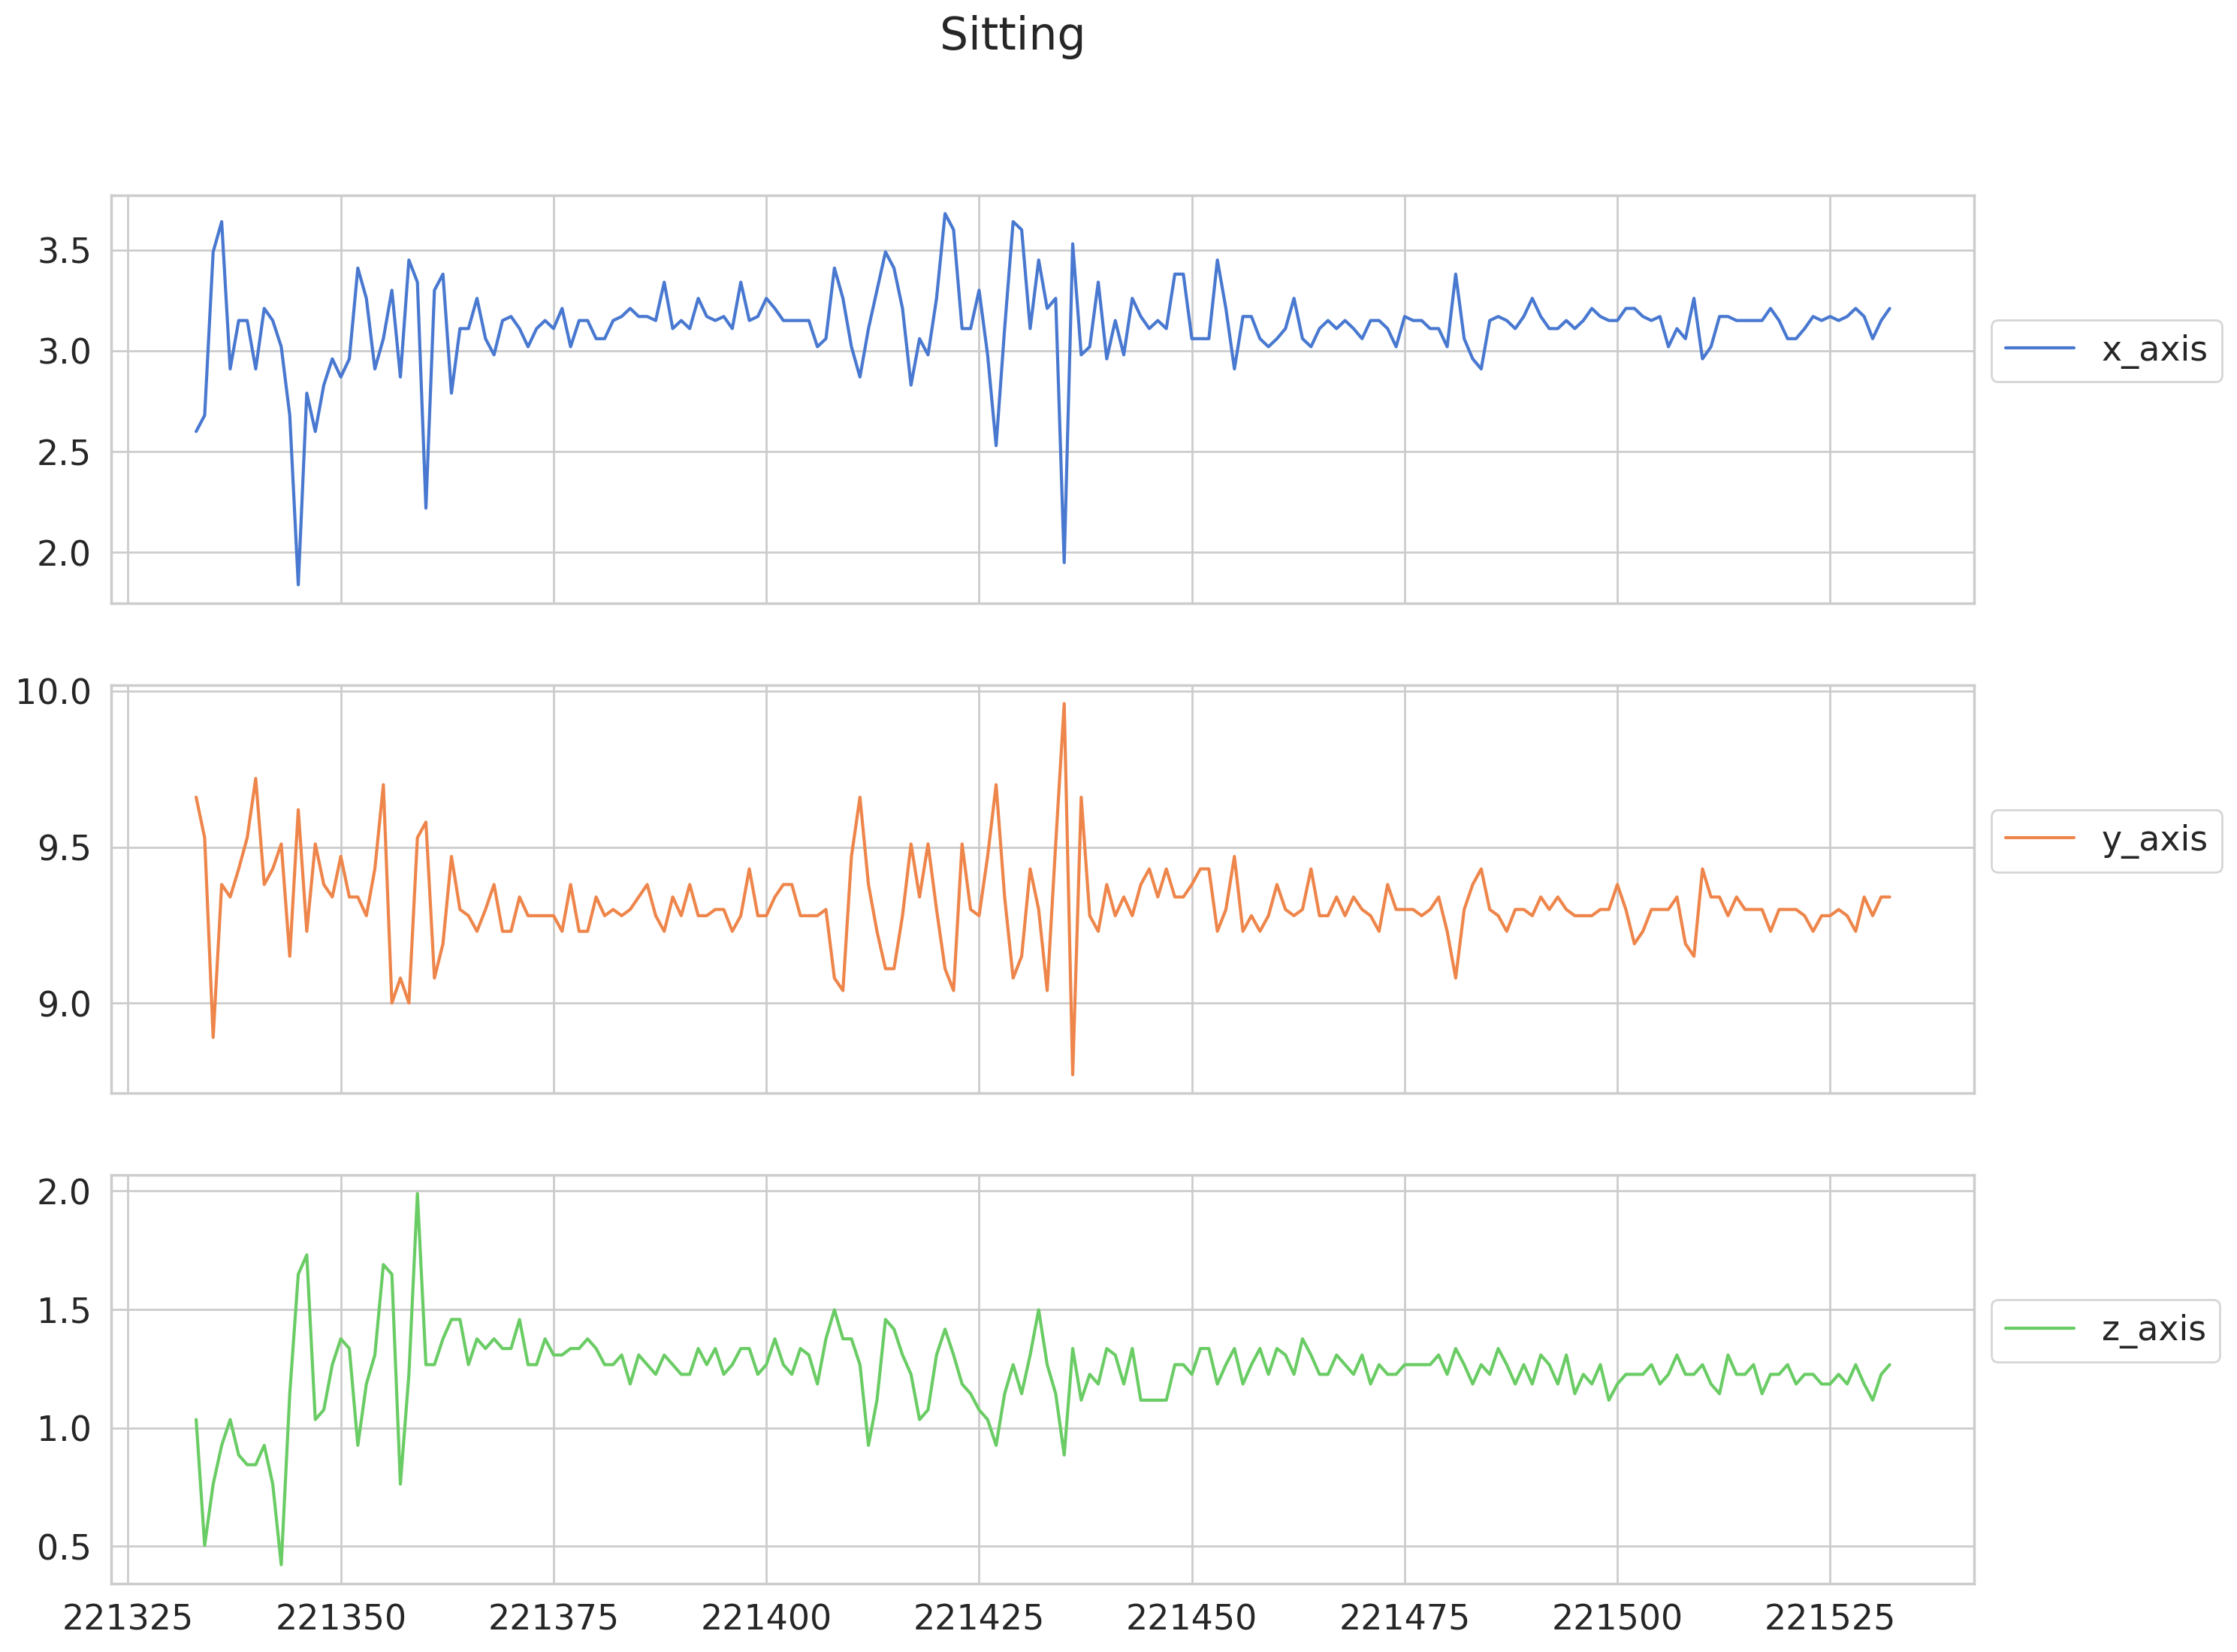

In [8]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


In [9]:
indexes = df[(df['activity'] != 'Sitting') & (df['activity'] != 'Standing')].index
df.drop(indexes, inplace=True)


In [10]:
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
221333,27,Sitting,12363992261000,2.60,9.66,1.035146,4
221334,27,Sitting,12364042279000,2.68,9.53,0.503953,4
221335,27,Sitting,12364092267000,3.49,8.89,0.762740,4
221336,27,Sitting,12364142316000,3.64,9.38,0.926184,4
221337,27,Sitting,12364192273000,2.91,9.34,1.035146,4
...,...,...,...,...,...,...,...
1098200,19,Sitting,131623331483000,9.00,-1.57,1.690000,4
1098201,19,Sitting,131623371431000,9.04,-1.46,1.730000,4
1098202,19,Sitting,131623411592000,9.08,-1.38,1.690000,4
1098203,19,Sitting,131623491487000,9.00,-1.46,1.730000,4


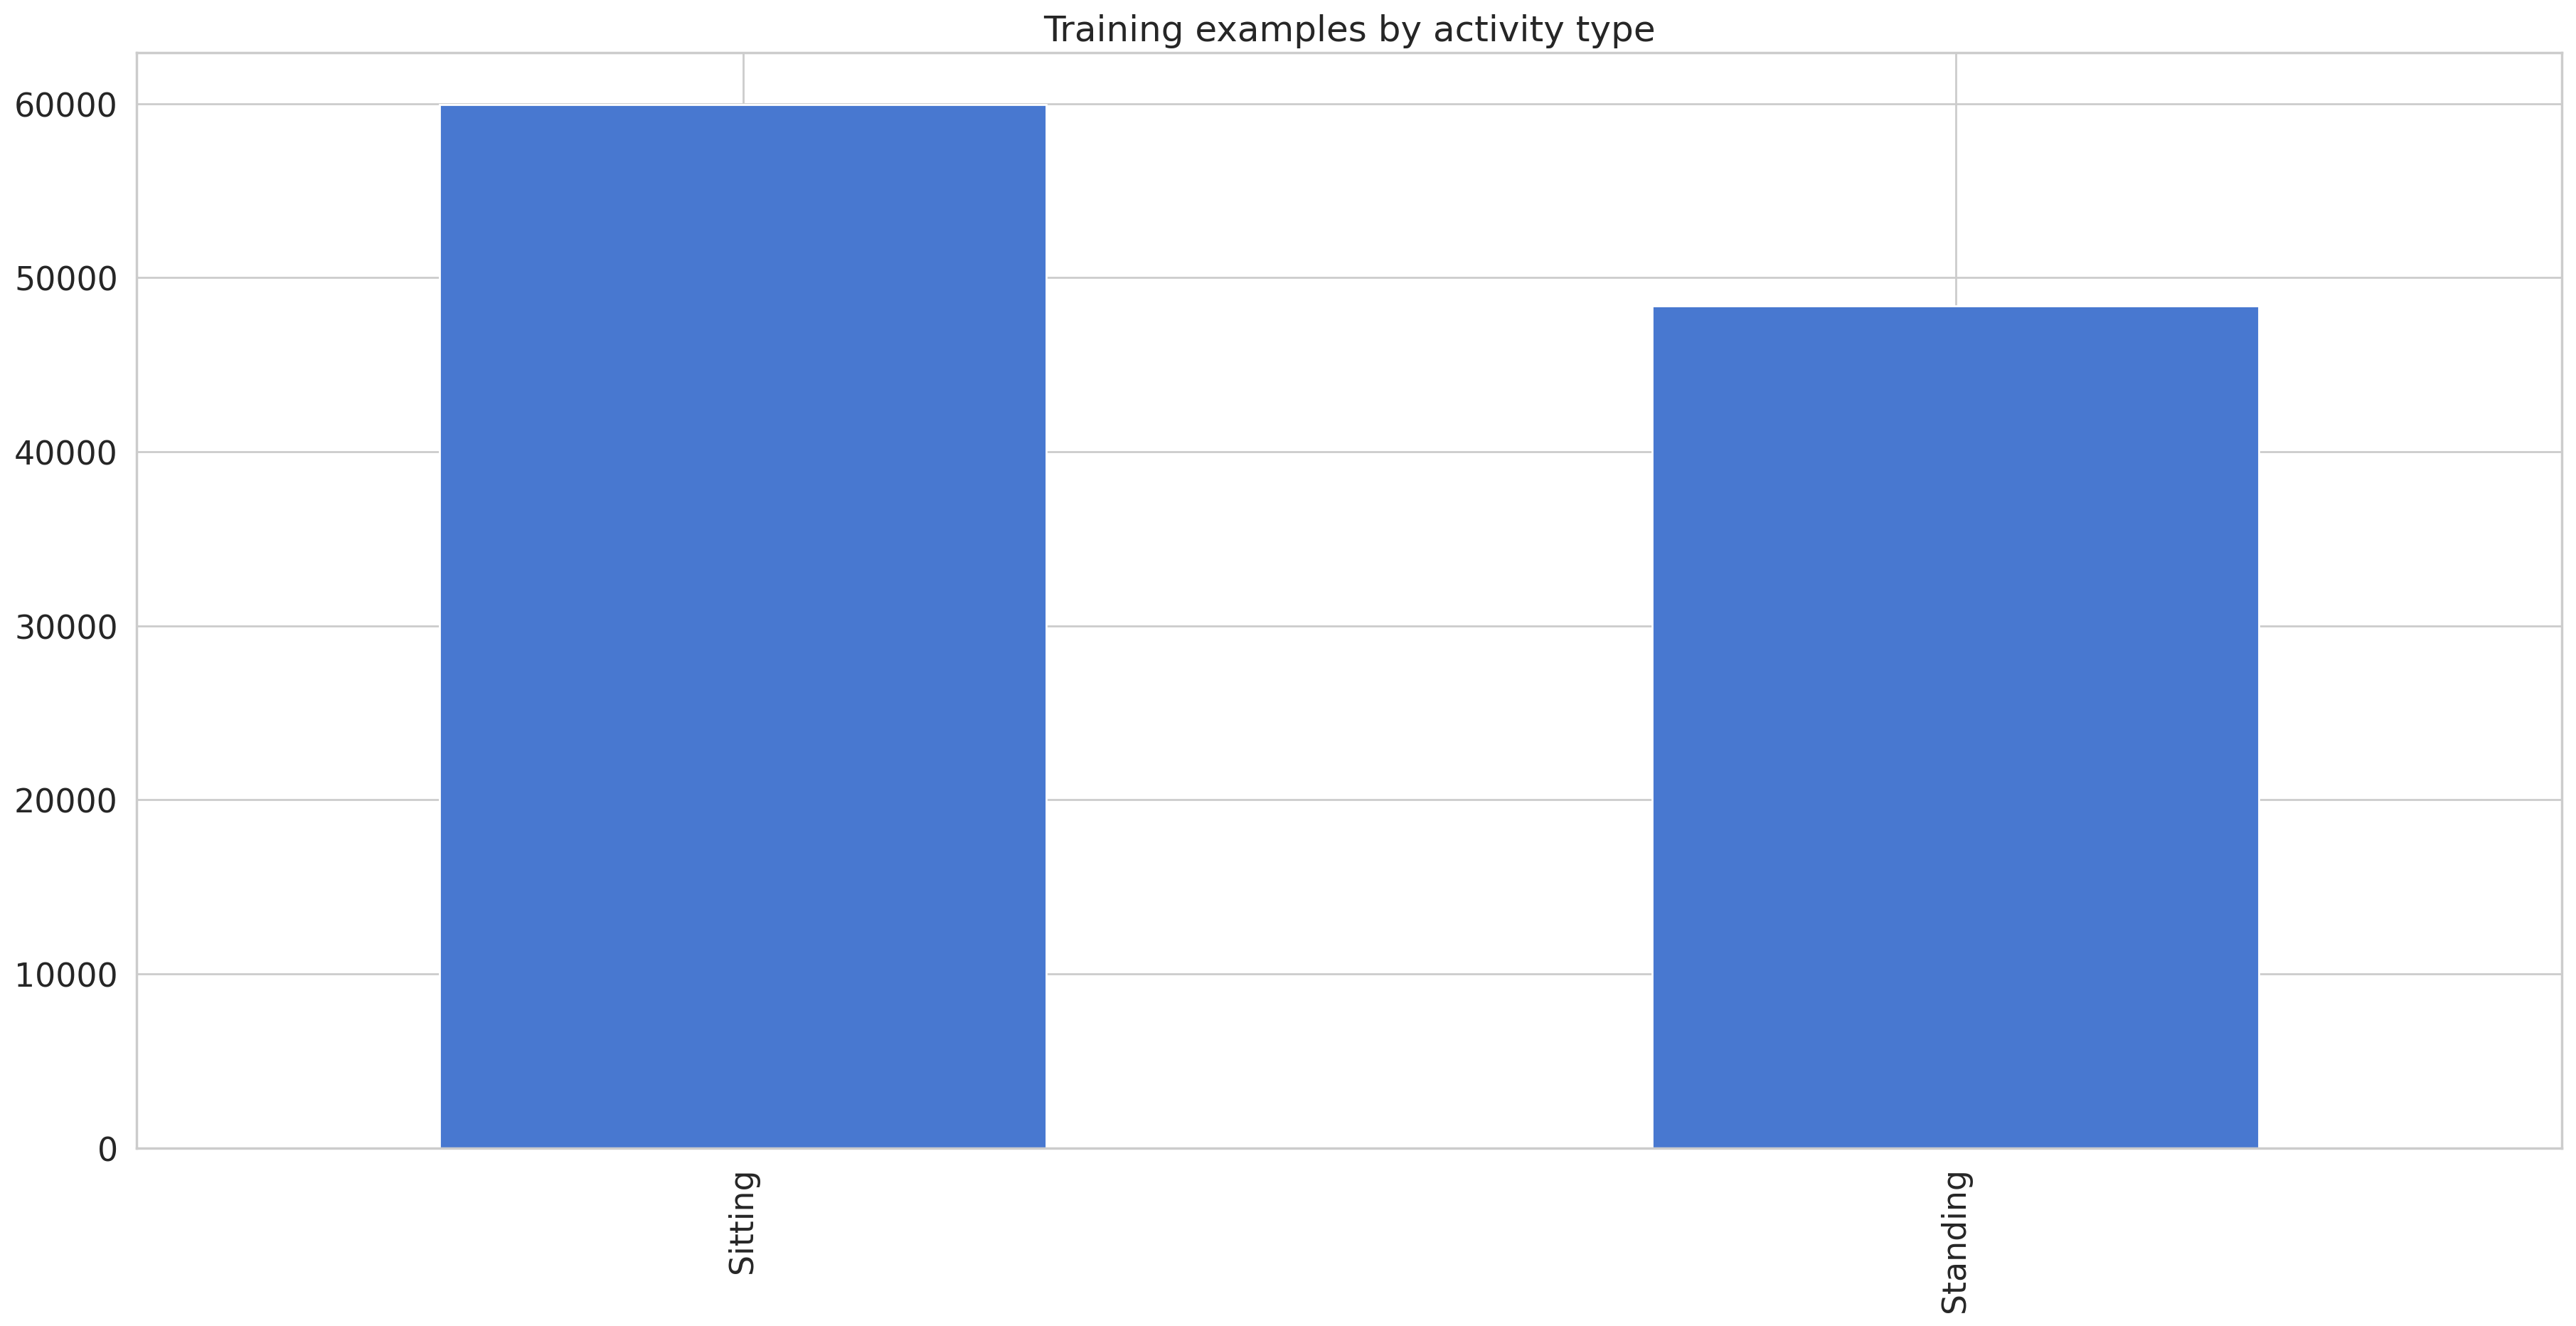

In [11]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [12]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
221333,27,Sitting,12363992261000,0.490260,0.617689,-0.241746,4
221334,27,Sitting,12364042279000,0.503247,0.599144,-0.311732,4
221335,27,Sitting,12364092267000,0.634740,0.507846,-0.277636,4
221336,27,Sitting,12364142316000,0.659091,0.577746,-0.256102,4
221337,27,Sitting,12364192273000,0.540584,0.572040,-0.241746,4
...,...,...,...,...,...,...,...
1098200,19,Sitting,131623331483000,1.529221,-0.984308,-0.155468,4
1098201,19,Sitting,131623371431000,1.535714,-0.968616,-0.150198,4
1098202,19,Sitting,131623411592000,1.542208,-0.957204,-0.155468,4
1098203,19,Sitting,131623491487000,1.529221,-0.968616,-0.150198,4


In [13]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)
y_data = y_data - 4
X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1730, 200, 3) (1730, 1)
(541, 200, 3) (541, 1)


In [14]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(1730, 200, 3) (1730, 2) (541, 200, 3) (541, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
#Epoch 500

BATCH_SIZE = 32

verbose,epochs,batch_size=1,10, BATCH_SIZE

n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 3, 2)

In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 198, 64)           640       
                                                                 
 flatten (Flatten)           (None, 12672)             0         
                                                                 
 dense (Dense)               (None, 128)               1622144   
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 1623042 (6.19 MB)
Trainable params: 1623042 (6.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
14/14 [==============================] - 2s 120ms/step - loss: 0.2369 - accuracy: 0.8936 - val_loss: 0.1976 - val_accuracy: 0.9307
Epoch 2/10
14/14 [==============================] - 1s 104ms/step - loss: 0.1171 - accuracy: 0.9549 - val_loss: 0.1063 - val_accuracy: 0.9515
Epoch 3/10
14/14 [==============================] - 1s 98ms/step - loss: 0.0852 - accuracy: 0.9624 - val_loss: 0.0915 - val_accuracy: 0.9630
Epoch 4/10
14/14 [==============================] - 1s 99ms/step - loss: 0.0712 - accuracy: 0.9694 - val_loss: 0.0758 - val_accuracy: 0.9723
Epoch 5/10
14/14 [==============================] - 1s 102ms/step - loss: 0.0617 - accuracy: 0.9780 - val_loss: 0.0706 - val_accuracy: 0.9723
Epoch 6/10
14/14 [==============================] - 1s 71ms/step - loss: 0.0554 - accuracy: 0.9792 - val_loss: 0.0709 - val_accuracy: 0.9746
Epoch 7/10
14/14 [==============================] - 1s 64ms/step - loss: 0.0478 - accuracy: 0.9838 - val_loss: 0.0591 - val_accuracy: 0.9931
Epoch 8/10

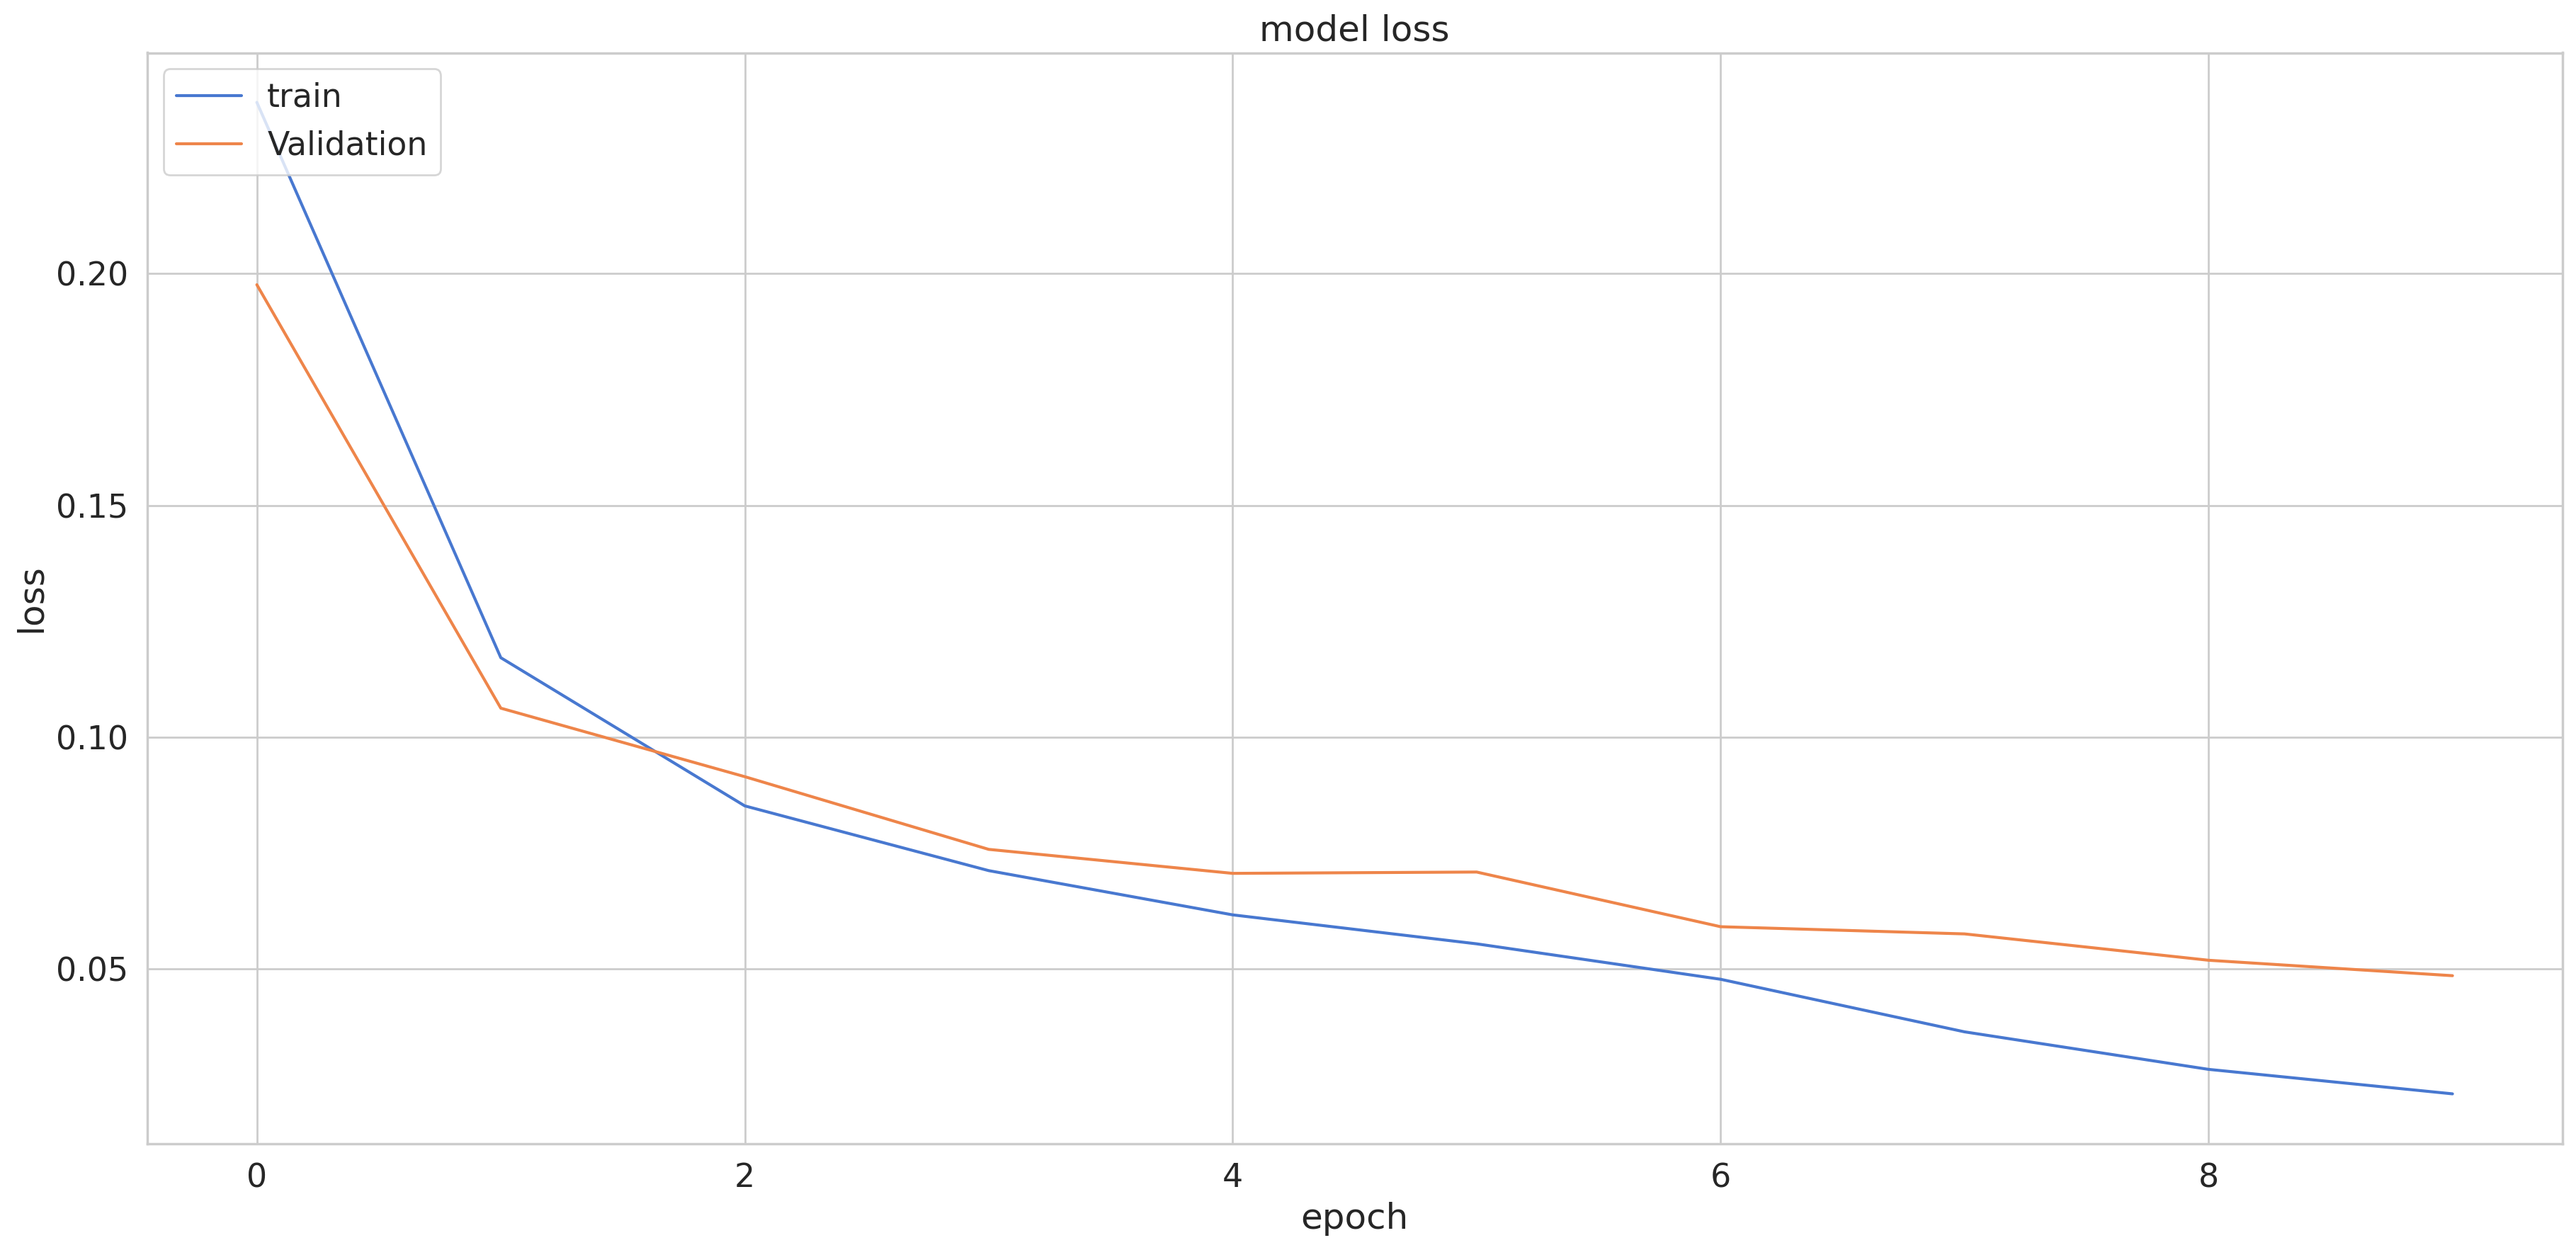

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

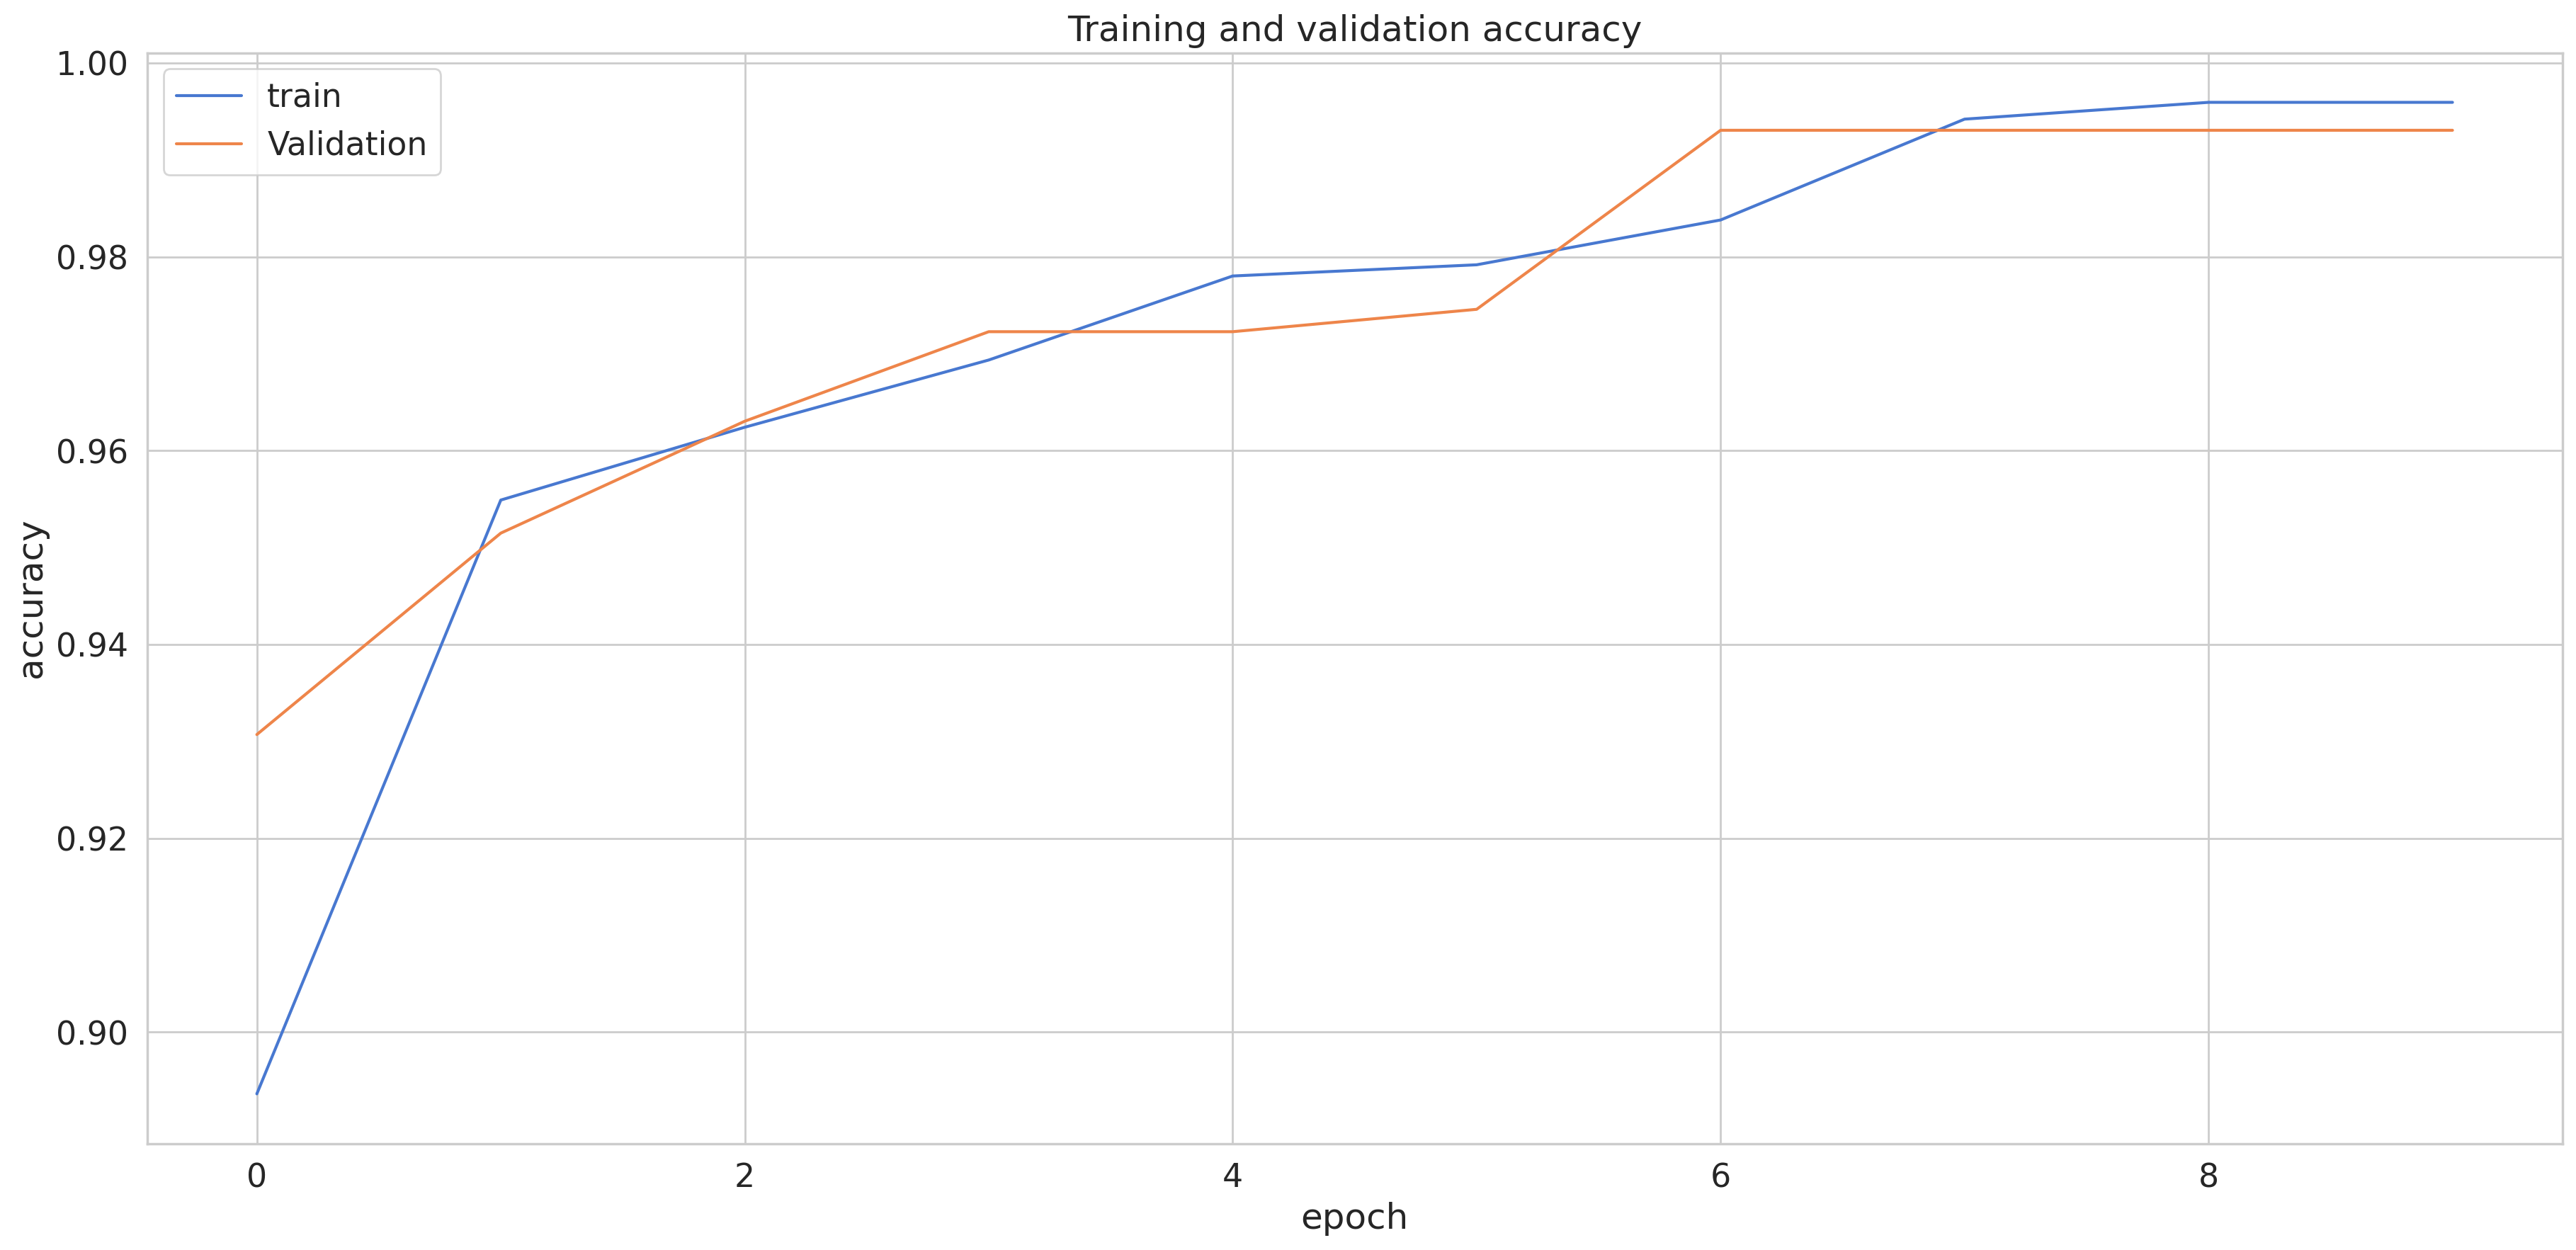

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

17/17 [==============================] - 0s 6ms/step
f1_score =  0.9944578137175538
0.9944547134935305
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       299
           1       0.99      1.00      0.99       242

    accuracy                           0.99       541
   macro avg       0.99      0.99      0.99       541
weighted avg       0.99      0.99      0.99       541



<Axes: >

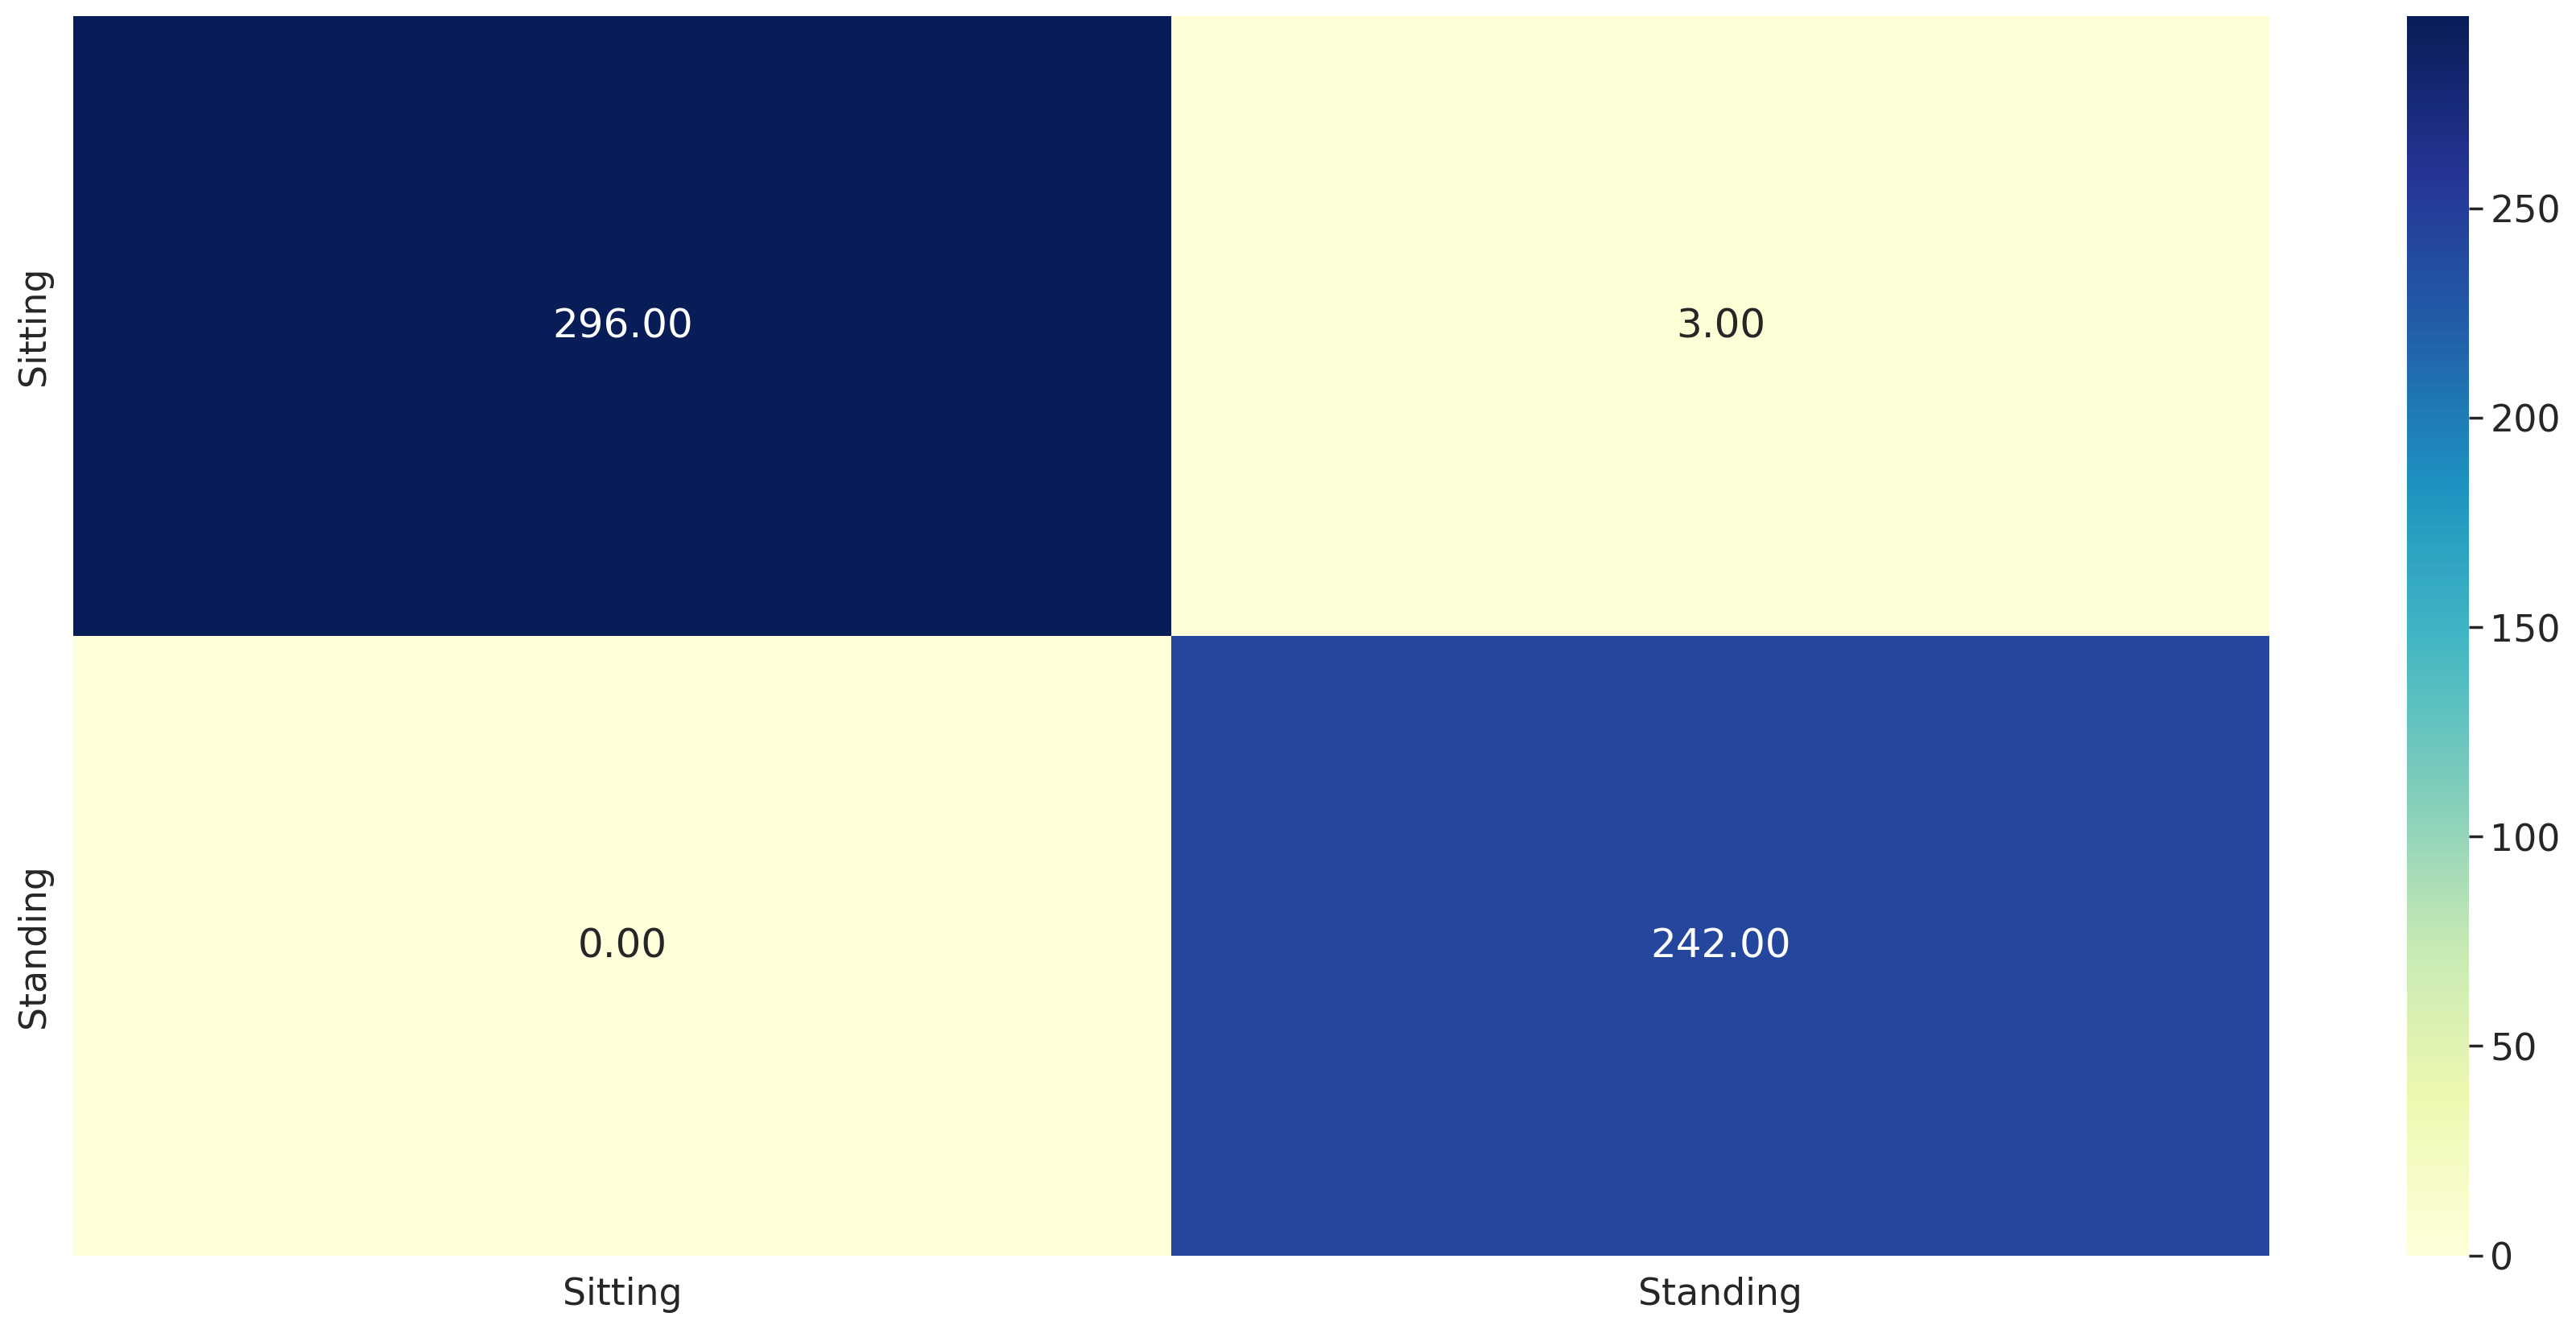

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2

In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 198, 64)           640       
                                                                 
 conv1d_12 (Conv1D)          (None, 196, 64)           12352     
                                                                 
 flatten_5 (Flatten)         (None, 12544)             0         
                                                                 
 dense_10 (Dense)            (None, 128)               1605760   
                                                                 
 dense_11 (Dense)            (None, 2)                 258       
                                                                 
Total params: 1619010 (6.18 MB)
Trainable params: 1619010 (6.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
14/14 [==============================] - 2s 118ms/step - loss: 0.1681 - accuracy: 0.9237 - val_loss: 0.1099 - val_accuracy: 0.9630
Epoch 2/10
14/14 [==============================] - 2s 158ms/step - loss: 0.0674 - accuracy: 0.9780 - val_loss: 0.0775 - val_accuracy: 0.9815
Epoch 3/10
14/14 [==============================] - 2s 148ms/step - loss: 0.0404 - accuracy: 0.9908 - val_loss: 0.0552 - val_accuracy: 0.9885
Epoch 4/10
14/14 [==============================] - 1s 92ms/step - loss: 0.0350 - accuracy: 0.9931 - val_loss: 0.0691 - val_accuracy: 0.9838
Epoch 5/10
14/14 [==============================] - 1s 98ms/step - loss: 0.0320 - accuracy: 0.9931 - val_loss: 0.0912 - val_accuracy: 0.9723
Epoch 6/10
14/14 [==============================] - 1s 93ms/step - loss: 0.0385 - accuracy: 0.9884 - val_loss: 0.0940 - val_accuracy: 0.9815
Epoch 7/10
14/14 [==============================] - 1s 98ms/step - loss: 0.0369 - accuracy: 0.9936 - val_loss: 0.0389 - val_accuracy: 0.9885
Epoch 8/10

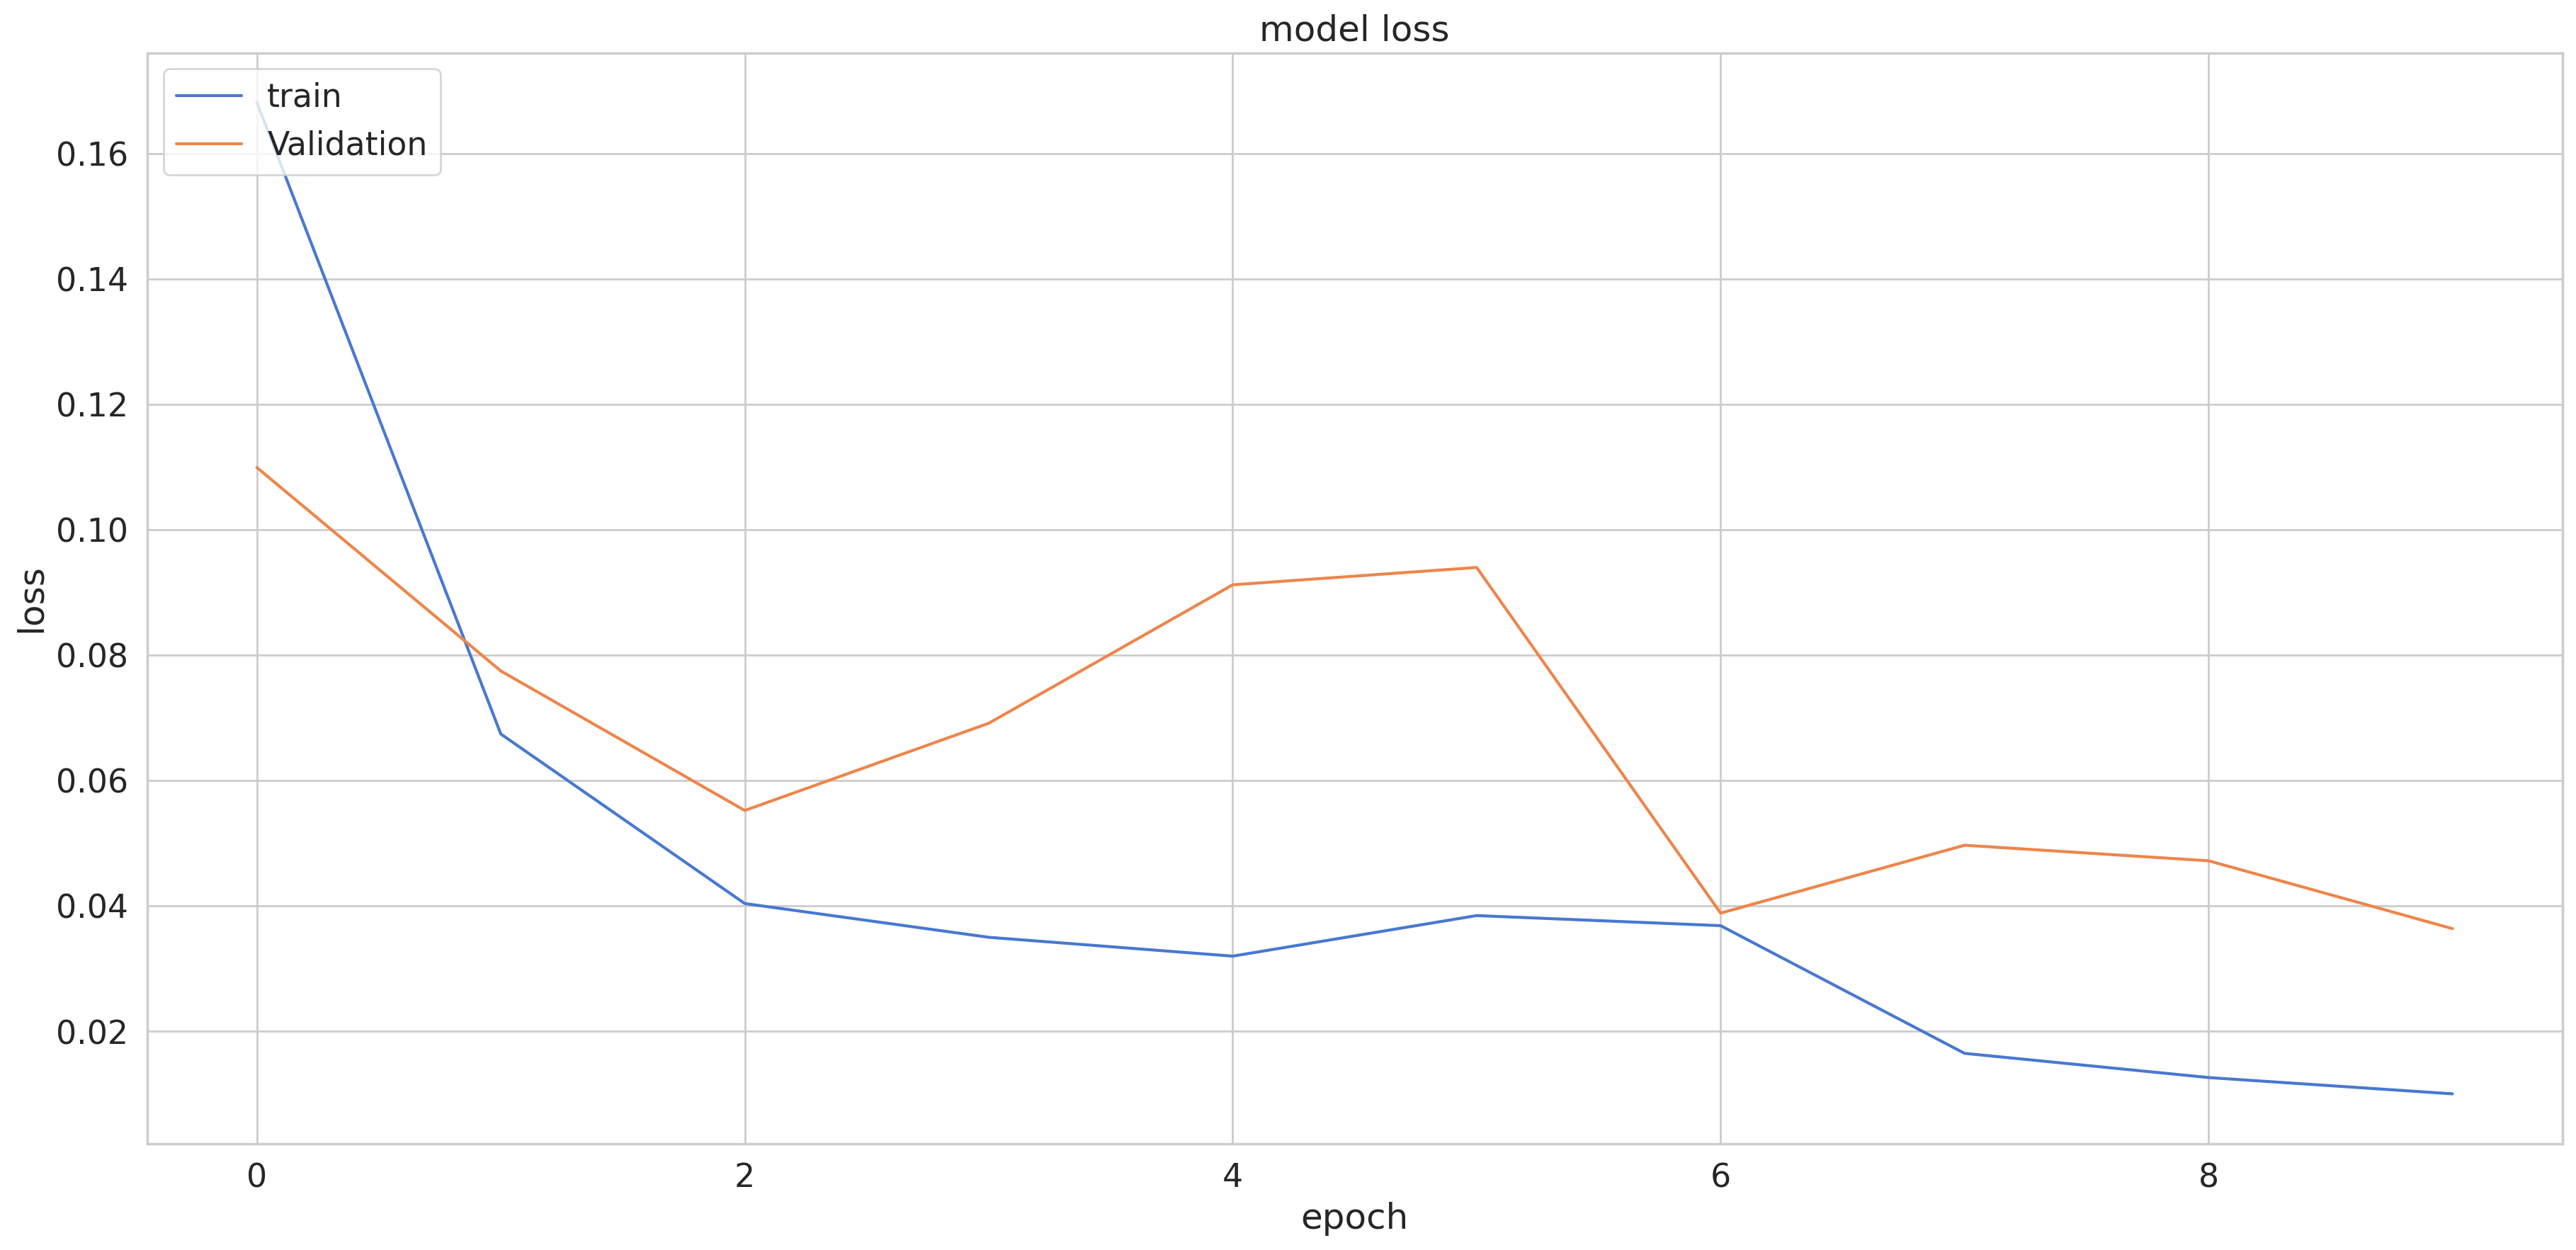

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

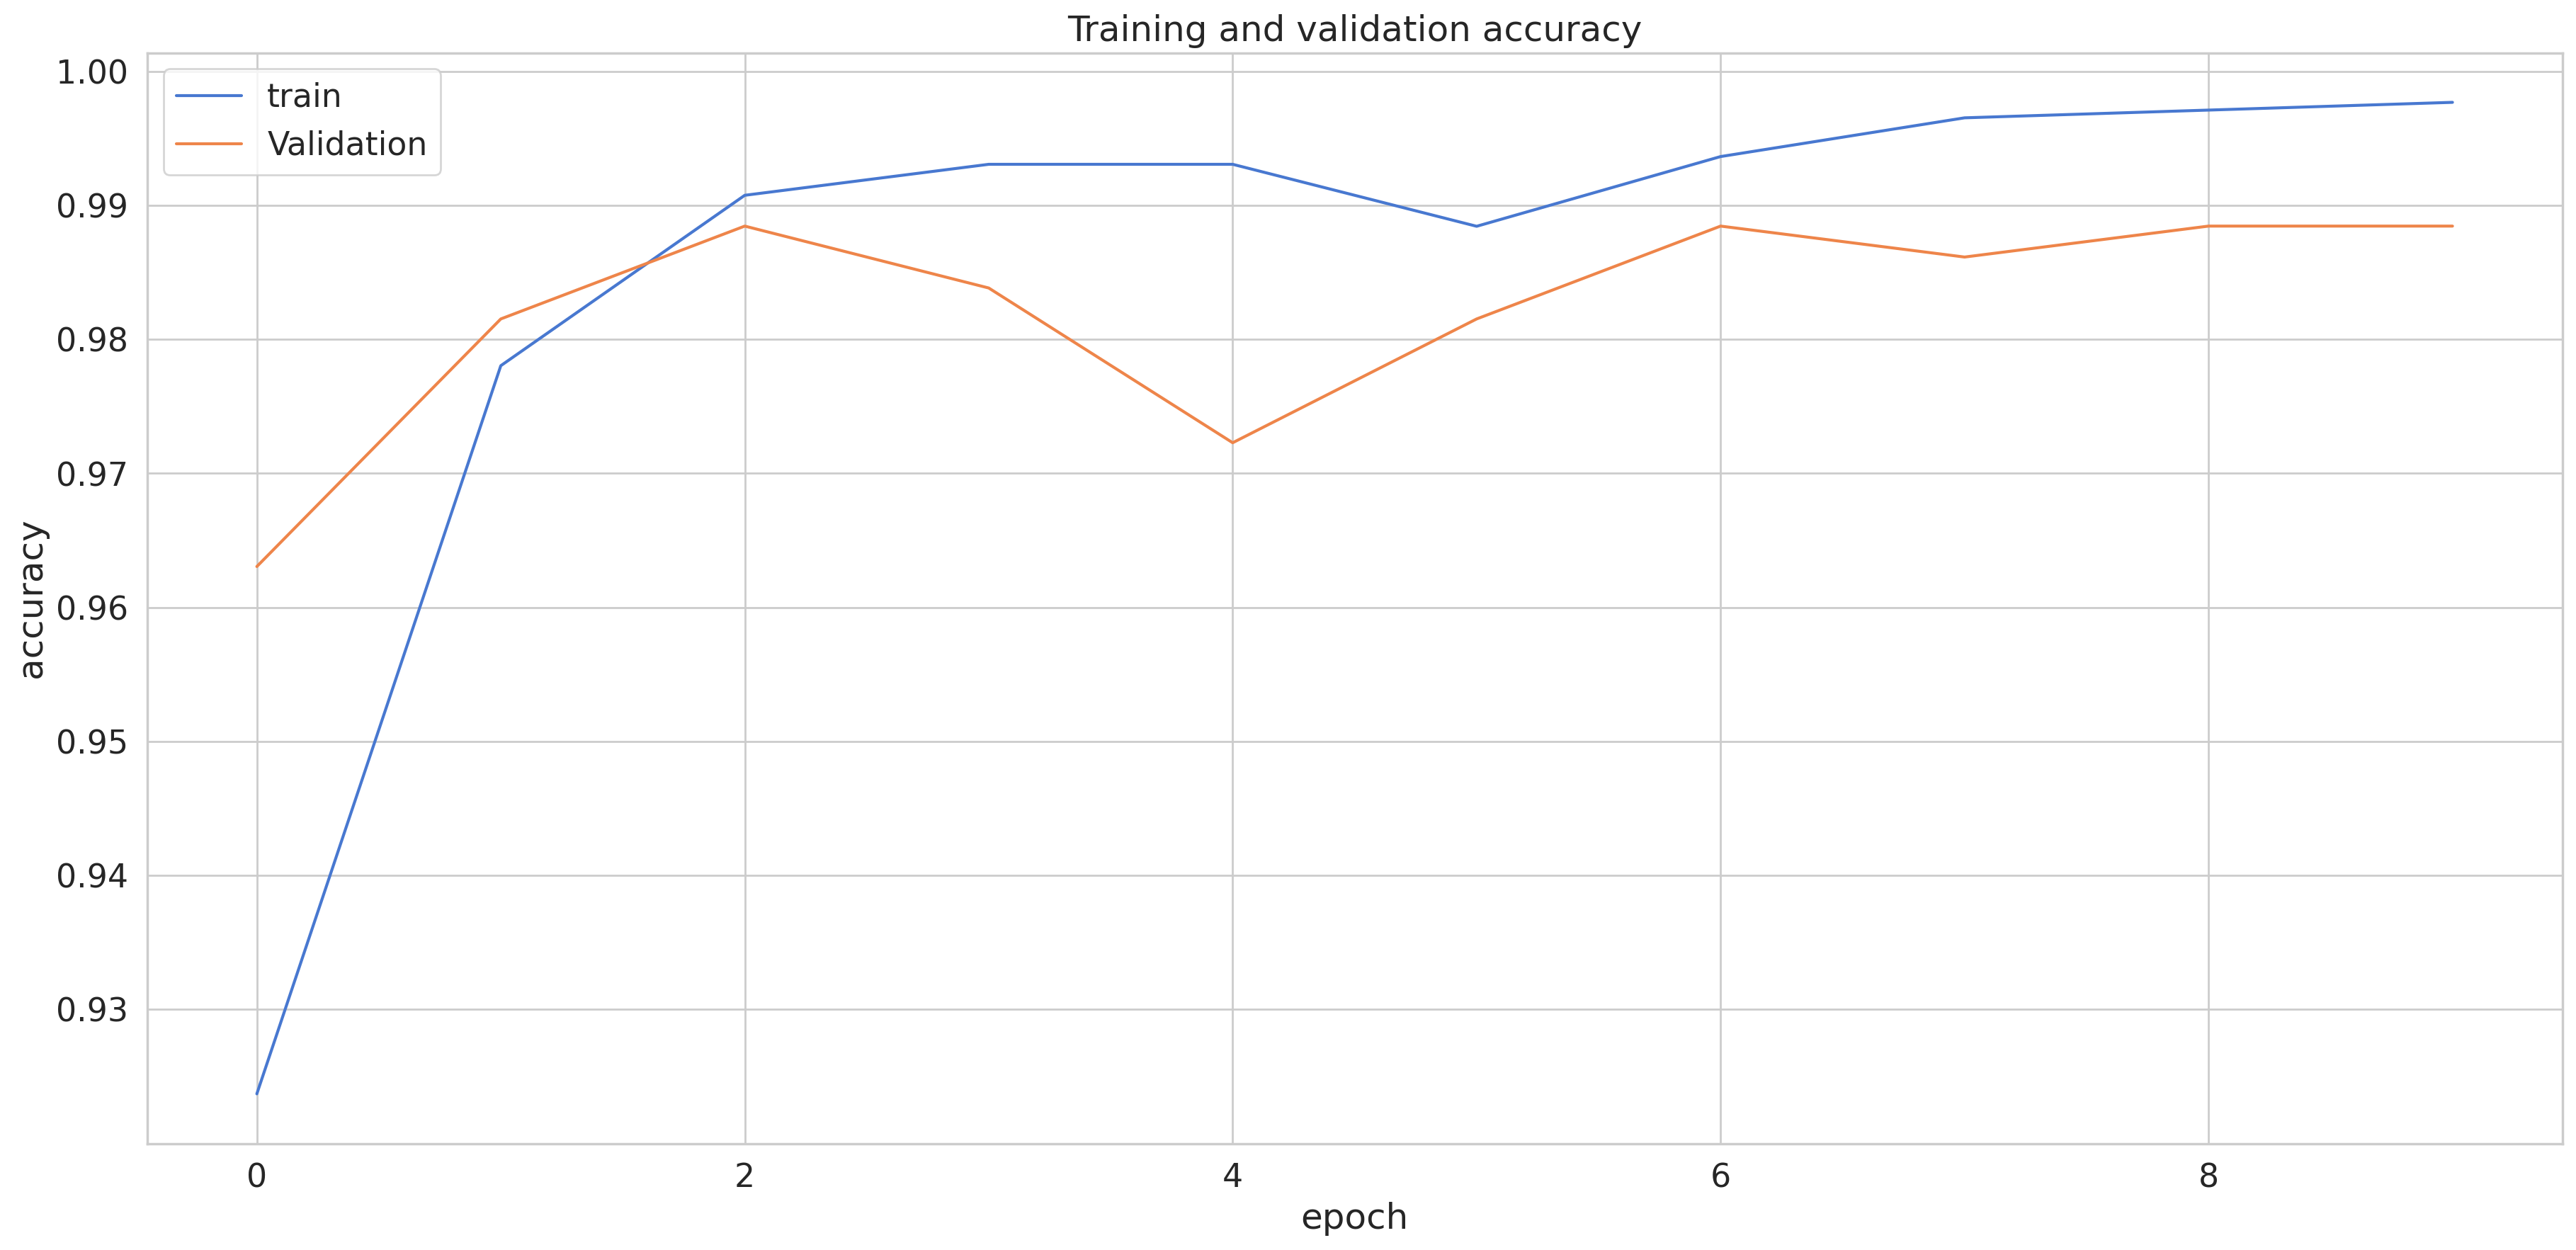

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

17/17 [==============================] - 0s 9ms/step
f1_score =  0.9889136387521597
0.988909426987061
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       299
           1       0.98      0.99      0.99       242

    accuracy                           0.99       541
   macro avg       0.99      0.99      0.99       541
weighted avg       0.99      0.99      0.99       541



<Axes: >

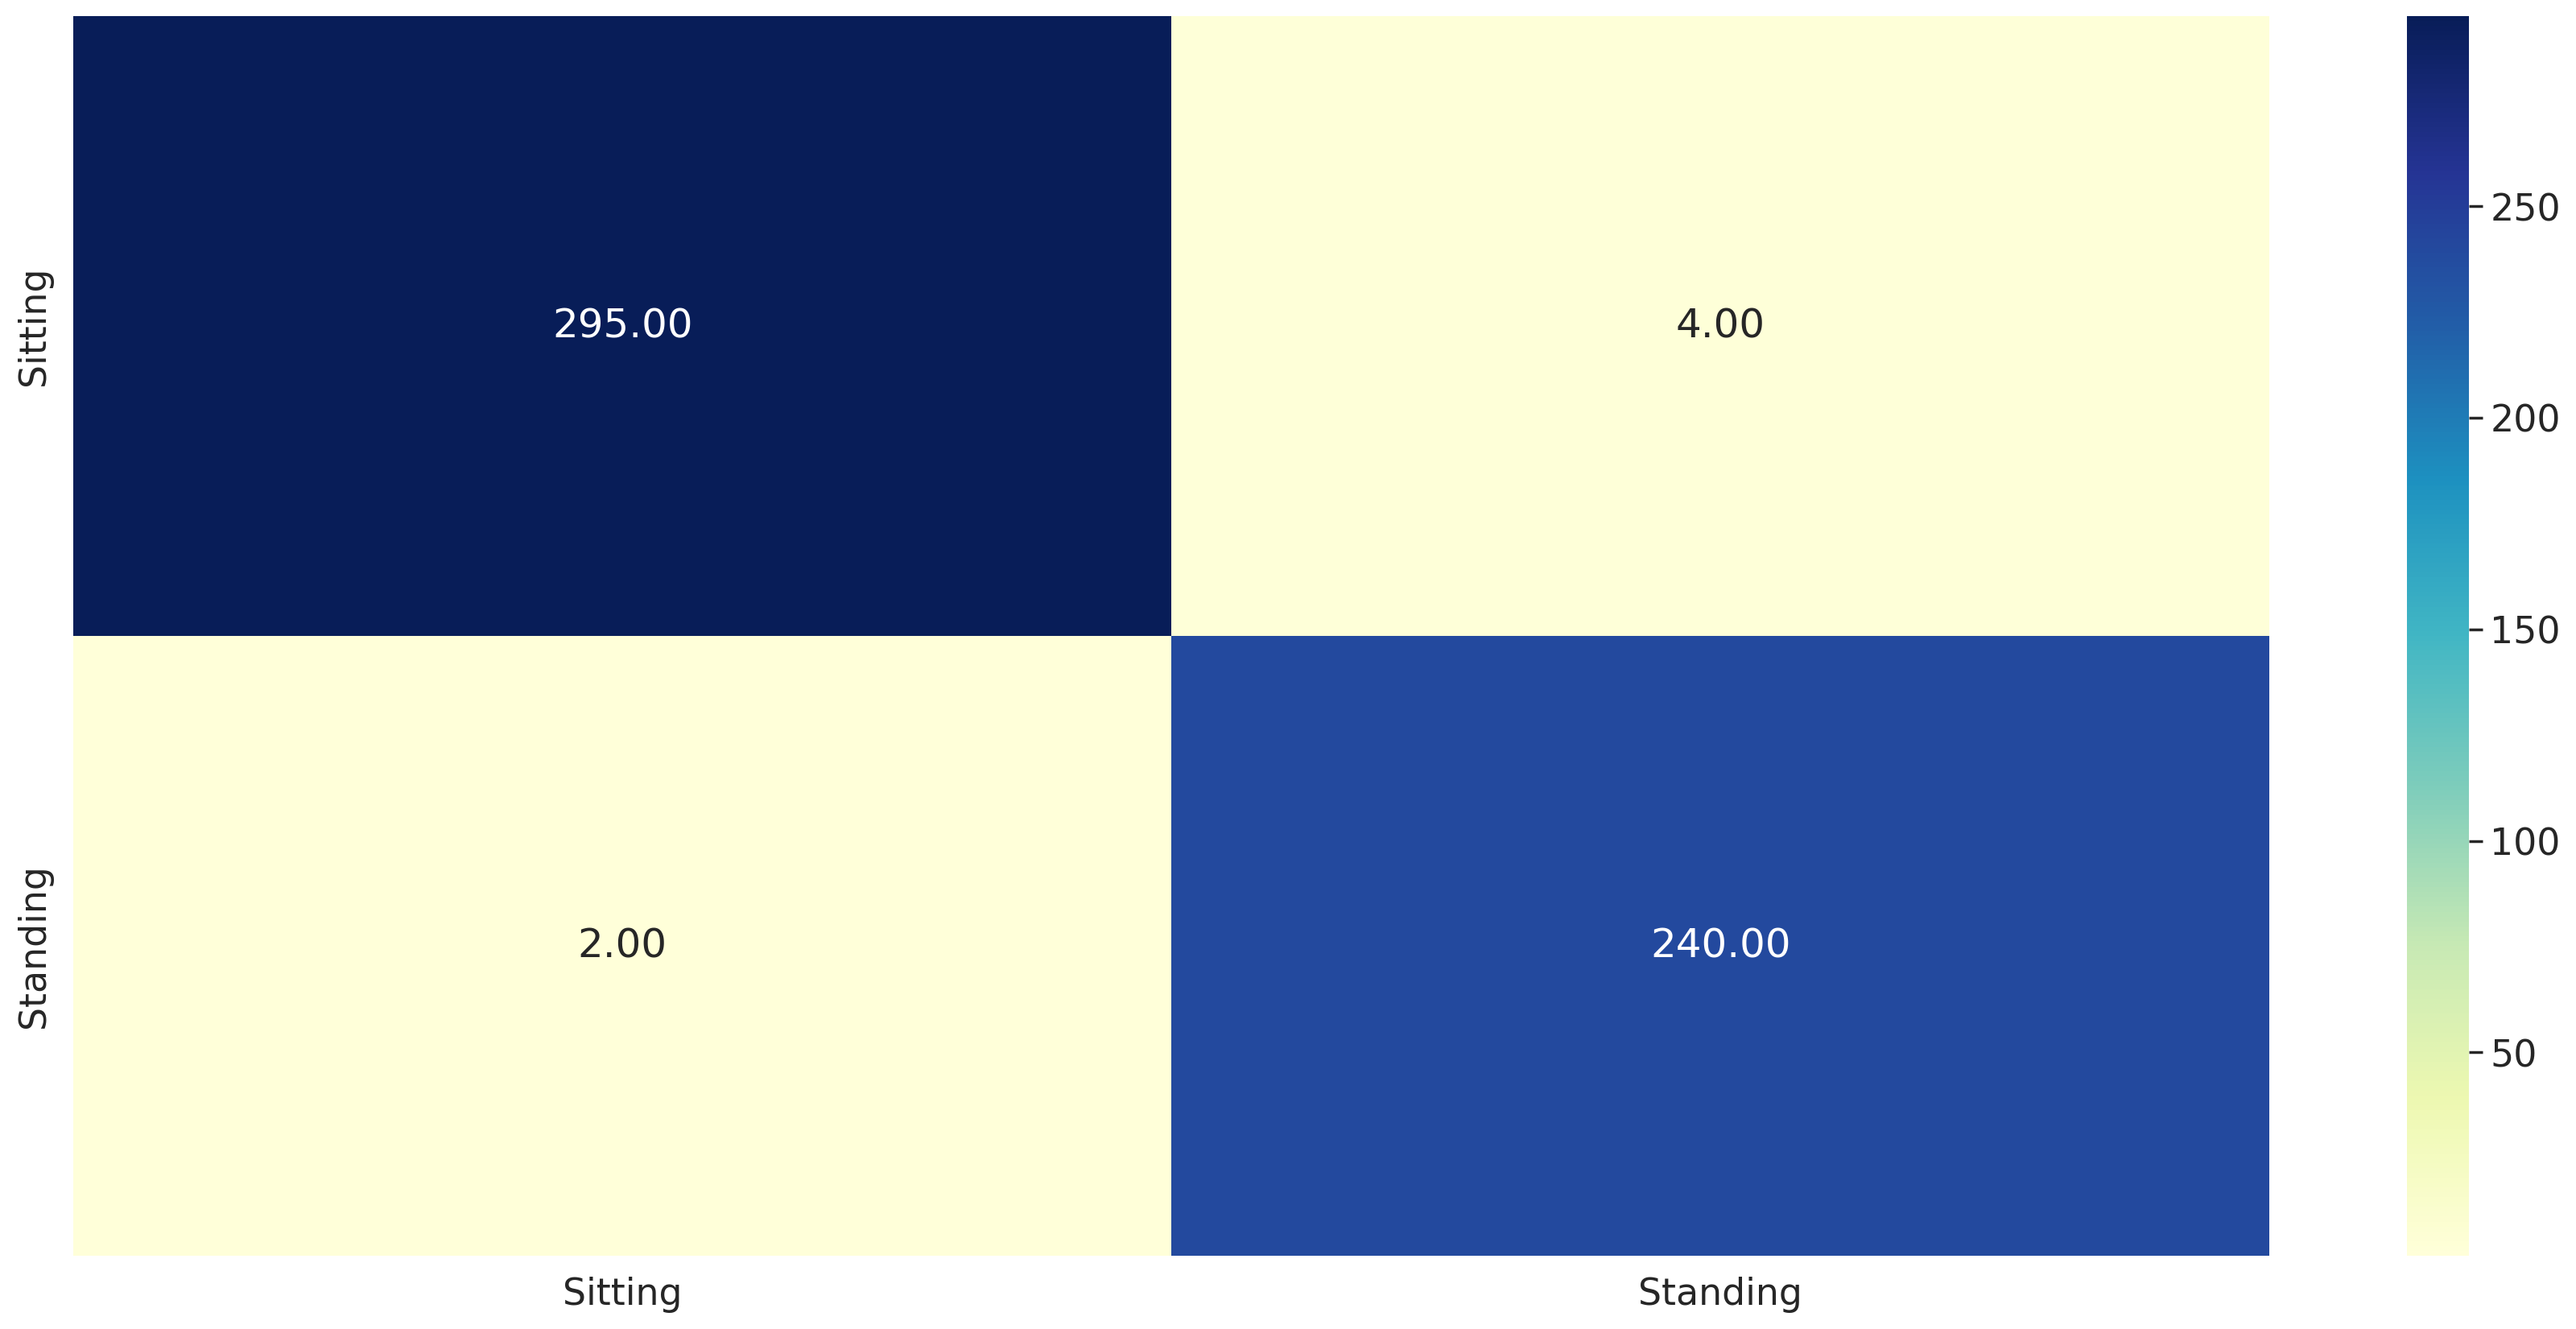

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN3

In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 198, 64)           640       
                                                                 
 conv1d_14 (Conv1D)          (None, 196, 64)           12352     
                                                                 
 conv1d_15 (Conv1D)          (None, 194, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 97, 64)            0         
 g1D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 6208)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               794752    
                                                      

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
14/14 [==============================] - 3s 137ms/step - loss: 0.2003 - accuracy: 0.9156 - val_loss: 0.1154 - val_accuracy: 0.9584
Epoch 2/10
14/14 [==============================] - 2s 121ms/step - loss: 0.0766 - accuracy: 0.9746 - val_loss: 0.0663 - val_accuracy: 0.9861
Epoch 3/10
14/14 [==============================] - 3s 209ms/step - loss: 0.0524 - accuracy: 0.9809 - val_loss: 0.0564 - val_accuracy: 0.9838
Epoch 4/10
14/14 [==============================] - 2s 171ms/step - loss: 0.0335 - accuracy: 0.9948 - val_loss: 0.0560 - val_accuracy: 0.9861
Epoch 5/10
14/14 [==============================] - 2s 121ms/step - loss: 0.0270 - accuracy: 0.9960 - val_loss: 0.0423 - val_accuracy: 0.9885
Epoch 6/10
14/14 [==============================] - 2s 120ms/step - loss: 0.0285 - accuracy: 0.9948 - val_loss: 0.0525 - val_accuracy: 0.9861
Epoch 7/10
14/14 [==============================] - 2s 120ms/step - loss: 0.0214 - accuracy: 0.9960 - val_loss: 0.0548 - val_accuracy: 0.9861
Epoch 

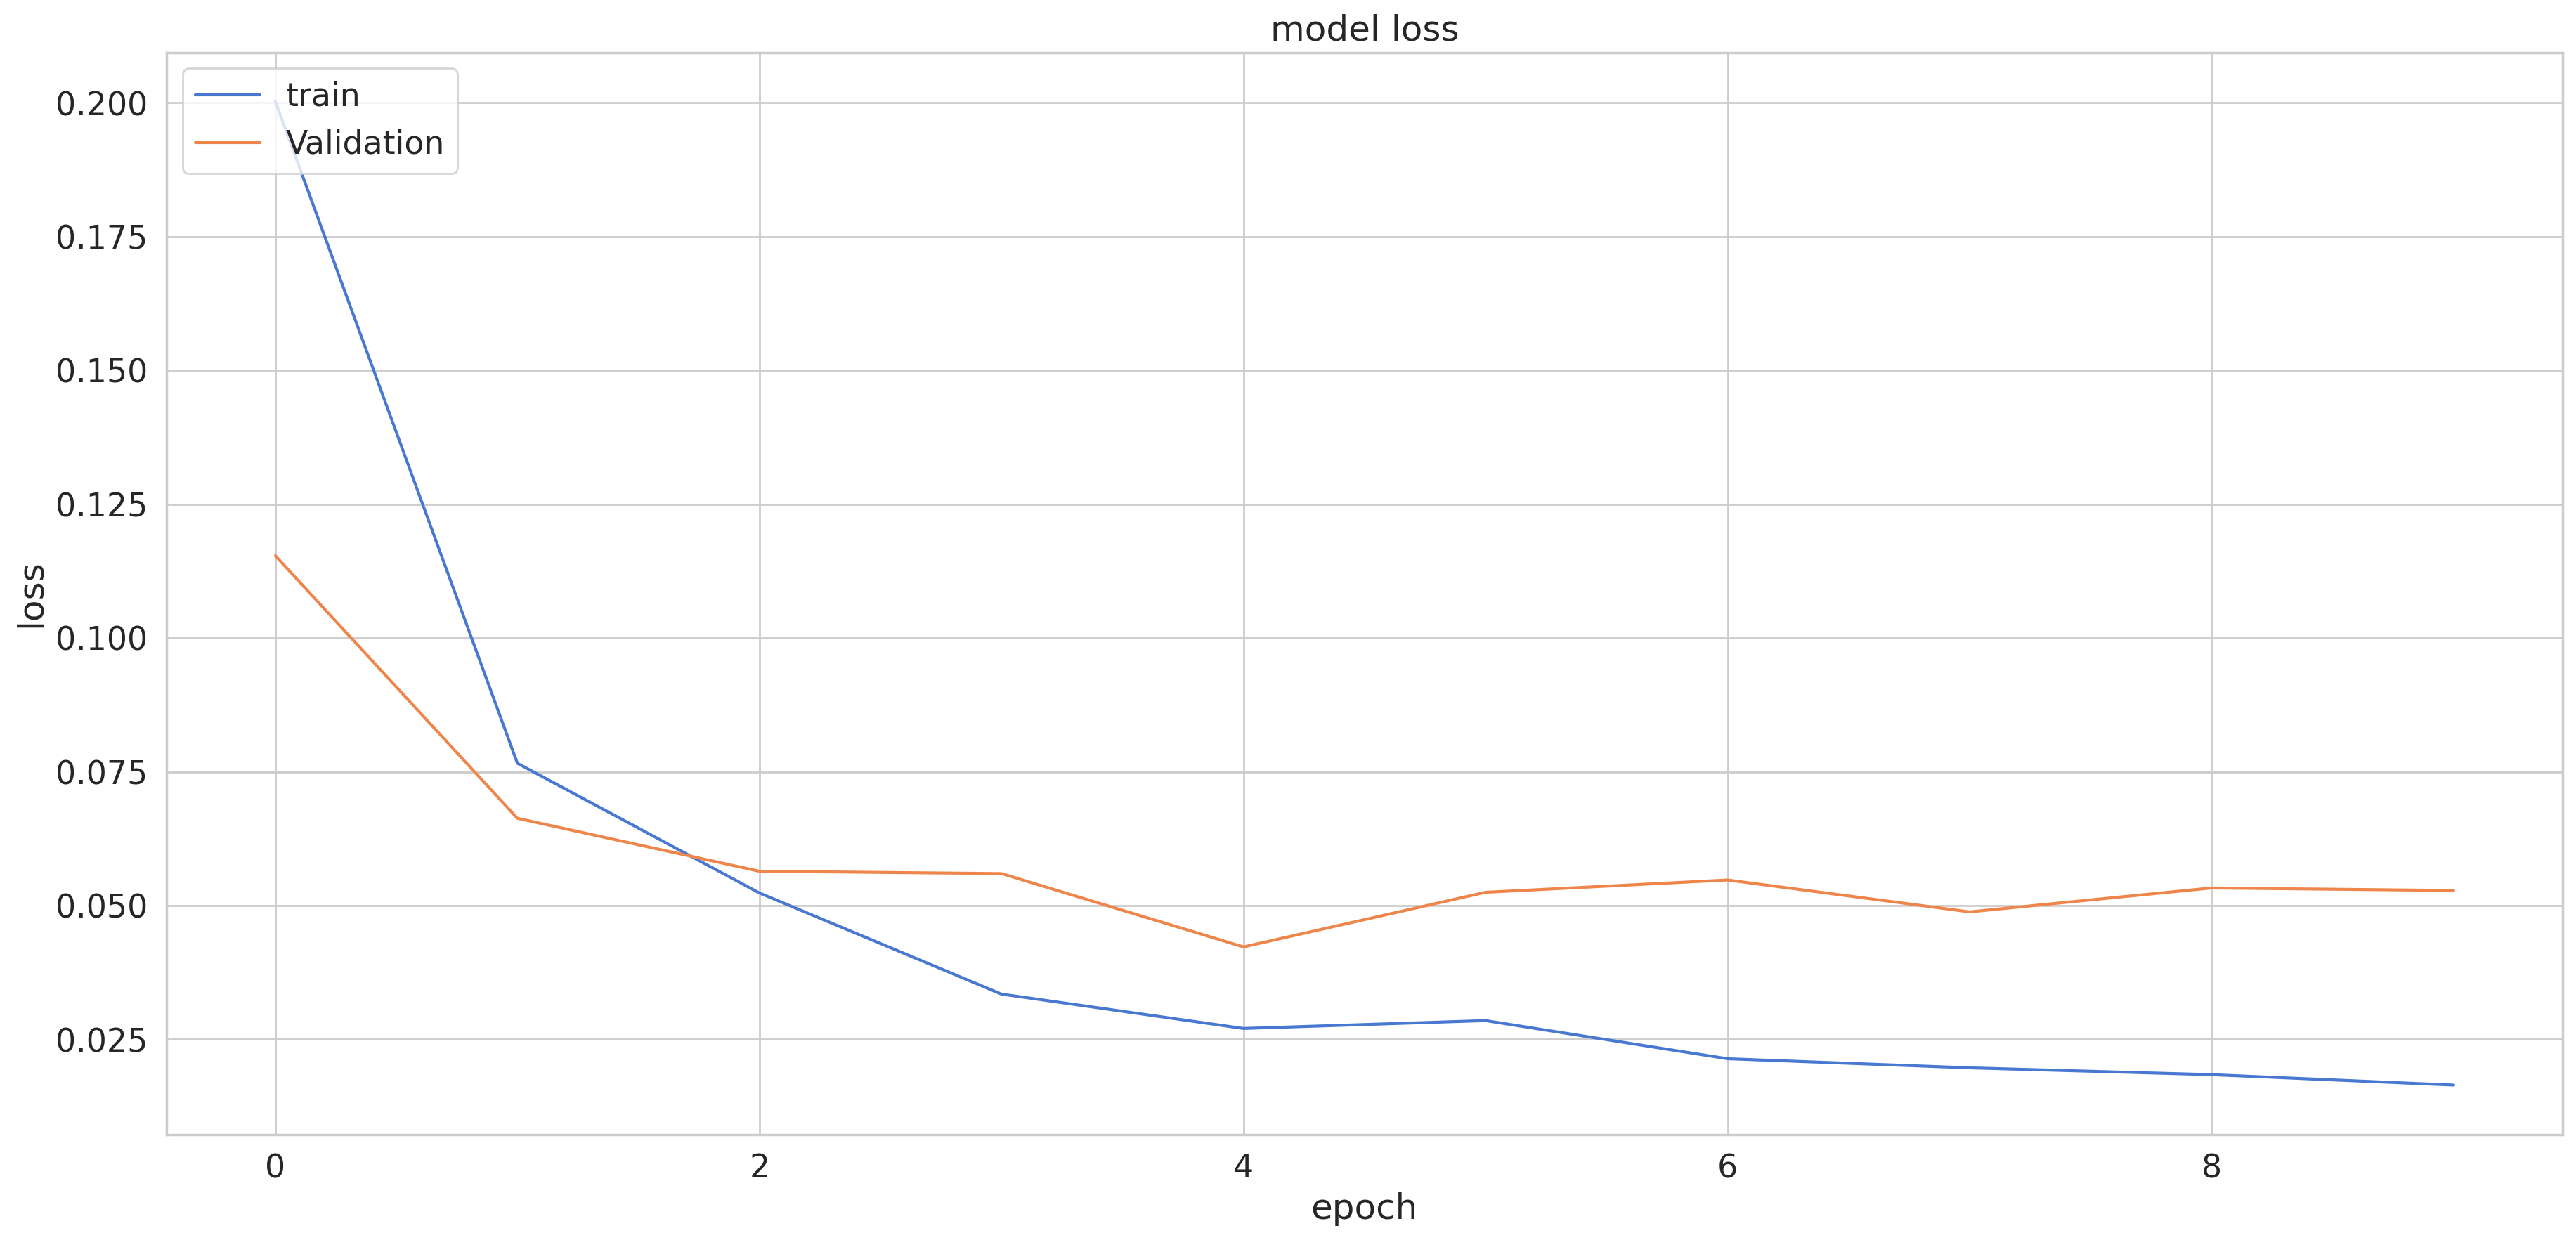

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

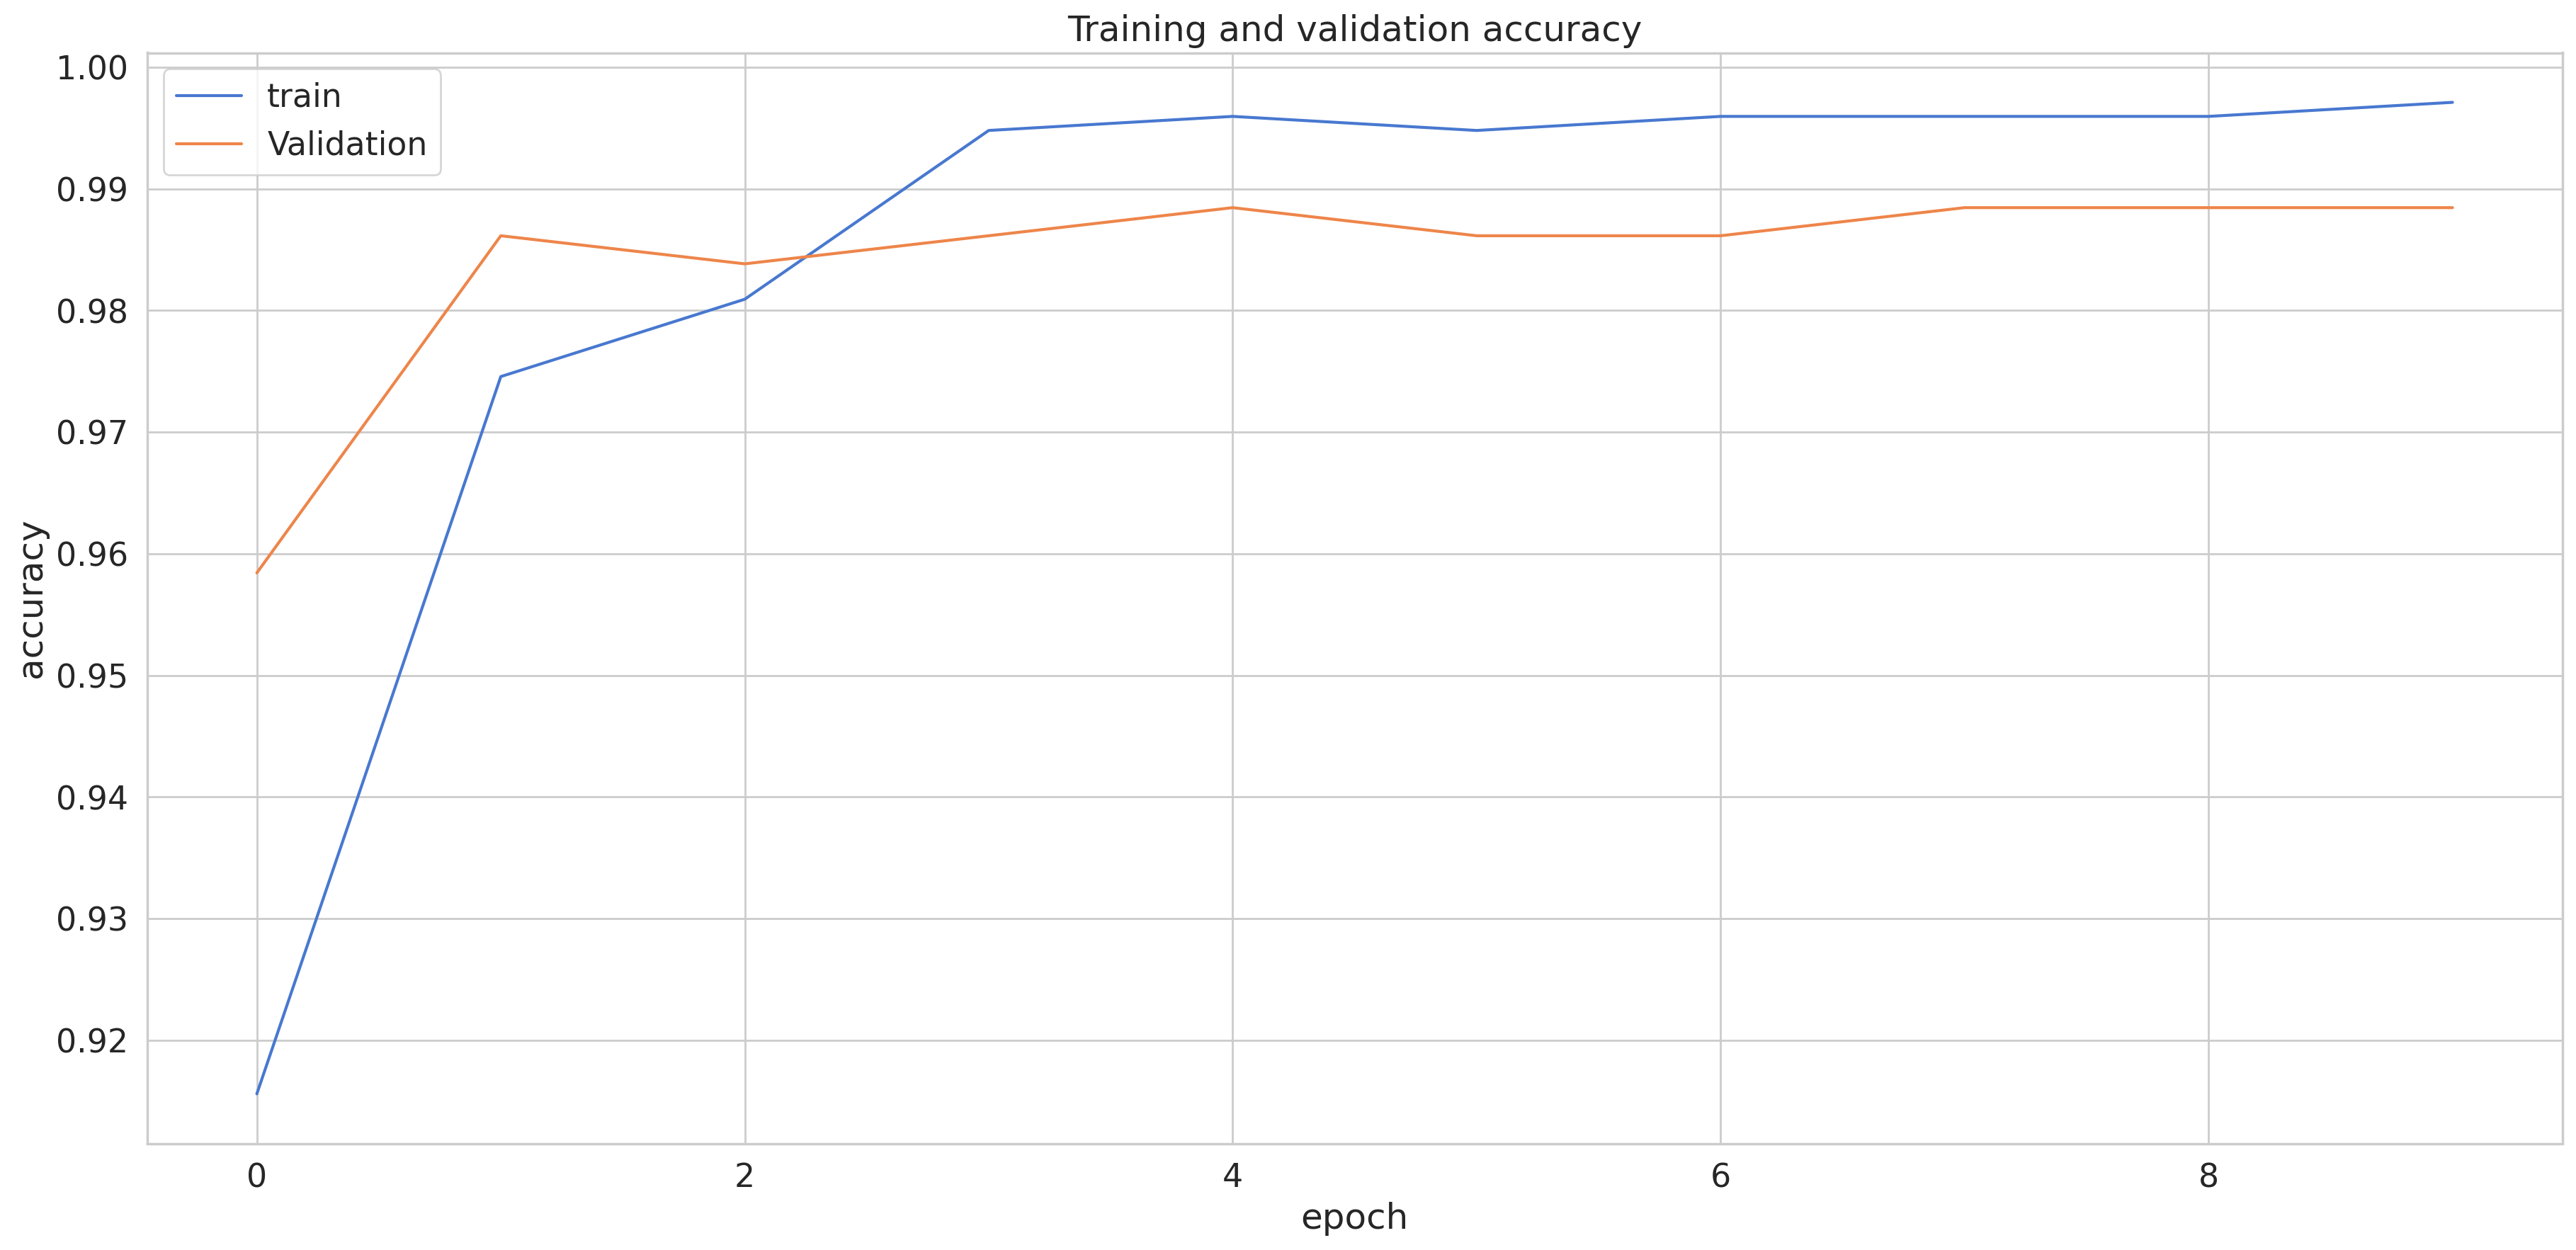

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

17/17 [==============================] - 0s 9ms/step
f1_score =  0.9889175381584703
0.988909426987061
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       299
           1       0.98      1.00      0.99       242

    accuracy                           0.99       541
   macro avg       0.99      0.99      0.99       541
weighted avg       0.99      0.99      0.99       541



<Axes: >

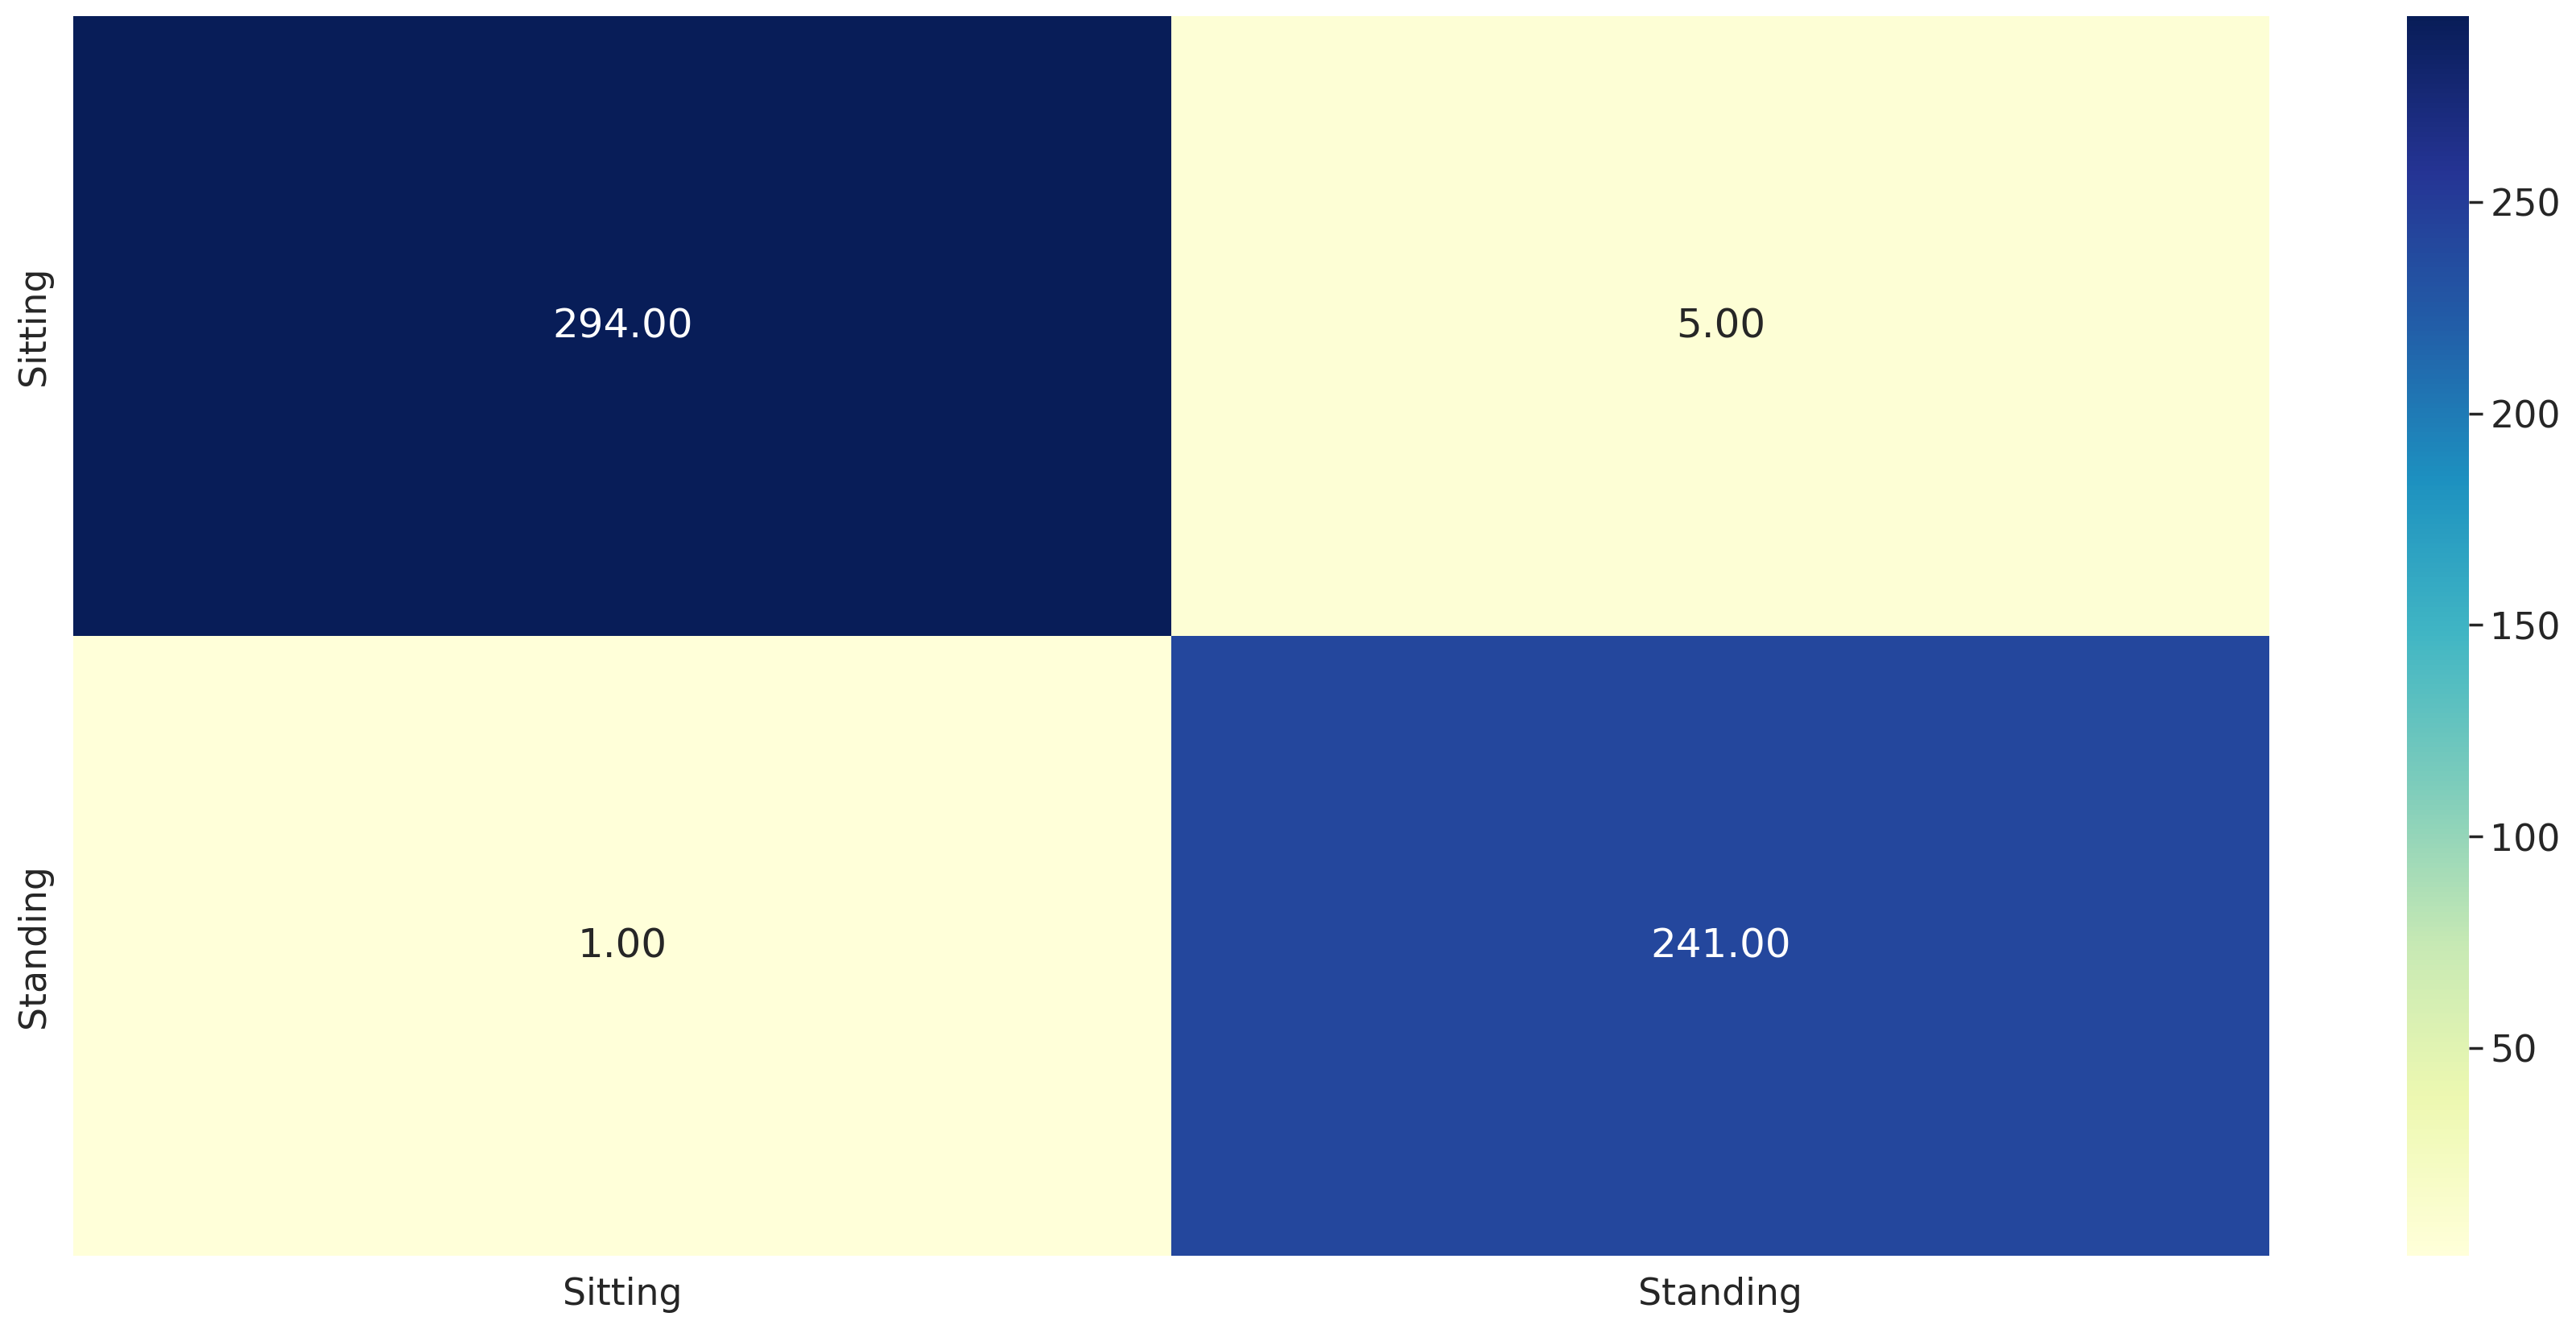

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN 4

In [ ]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 198, 64)           640       
                                                                 
 conv1d_17 (Conv1D)          (None, 196, 64)           12352     
                                                                 
 conv1d_18 (Conv1D)          (None, 194, 64)           12352     
                                                                 
 conv1d_19 (Conv1D)          (None, 192, 64)           12352     
                                                                 
 flatten_7 (Flatten)         (None, 12288)             0         
                                                                 
 dense_14 (Dense)            (None, 128)               1572992   
                                                                 
 dense_15 (Dense)            (None, 2)                

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
14/14 [==============================] - 4s 205ms/step - loss: 0.1950 - accuracy: 0.9208 - val_loss: 0.0959 - val_accuracy: 0.9654
Epoch 2/10
14/14 [==============================] - 2s 175ms/step - loss: 0.0601 - accuracy: 0.9838 - val_loss: 0.0791 - val_accuracy: 0.9769
Epoch 3/10
14/14 [==============================] - 3s 224ms/step - loss: 0.0415 - accuracy: 0.9902 - val_loss: 0.0753 - val_accuracy: 0.9861
Epoch 4/10
14/14 [==============================] - 4s 258ms/step - loss: 0.0322 - accuracy: 0.9931 - val_loss: 0.0430 - val_accuracy: 0.9908
Epoch 5/10
14/14 [==============================] - 2s 176ms/step - loss: 0.0287 - accuracy: 0.9936 - val_loss: 0.0656 - val_accuracy: 0.9885
Epoch 6/10
14/14 [==============================] - 2s 174ms/step - loss: 0.0272 - accuracy: 0.9954 - val_loss: 0.0588 - val_accuracy: 0.9885
Epoch 7/10
14/14 [==============================] - 2s 173ms/step - loss: 0.0221 - accuracy: 0.9960 - val_loss: 0.0356 - val_accuracy: 0.9908
Epoch 

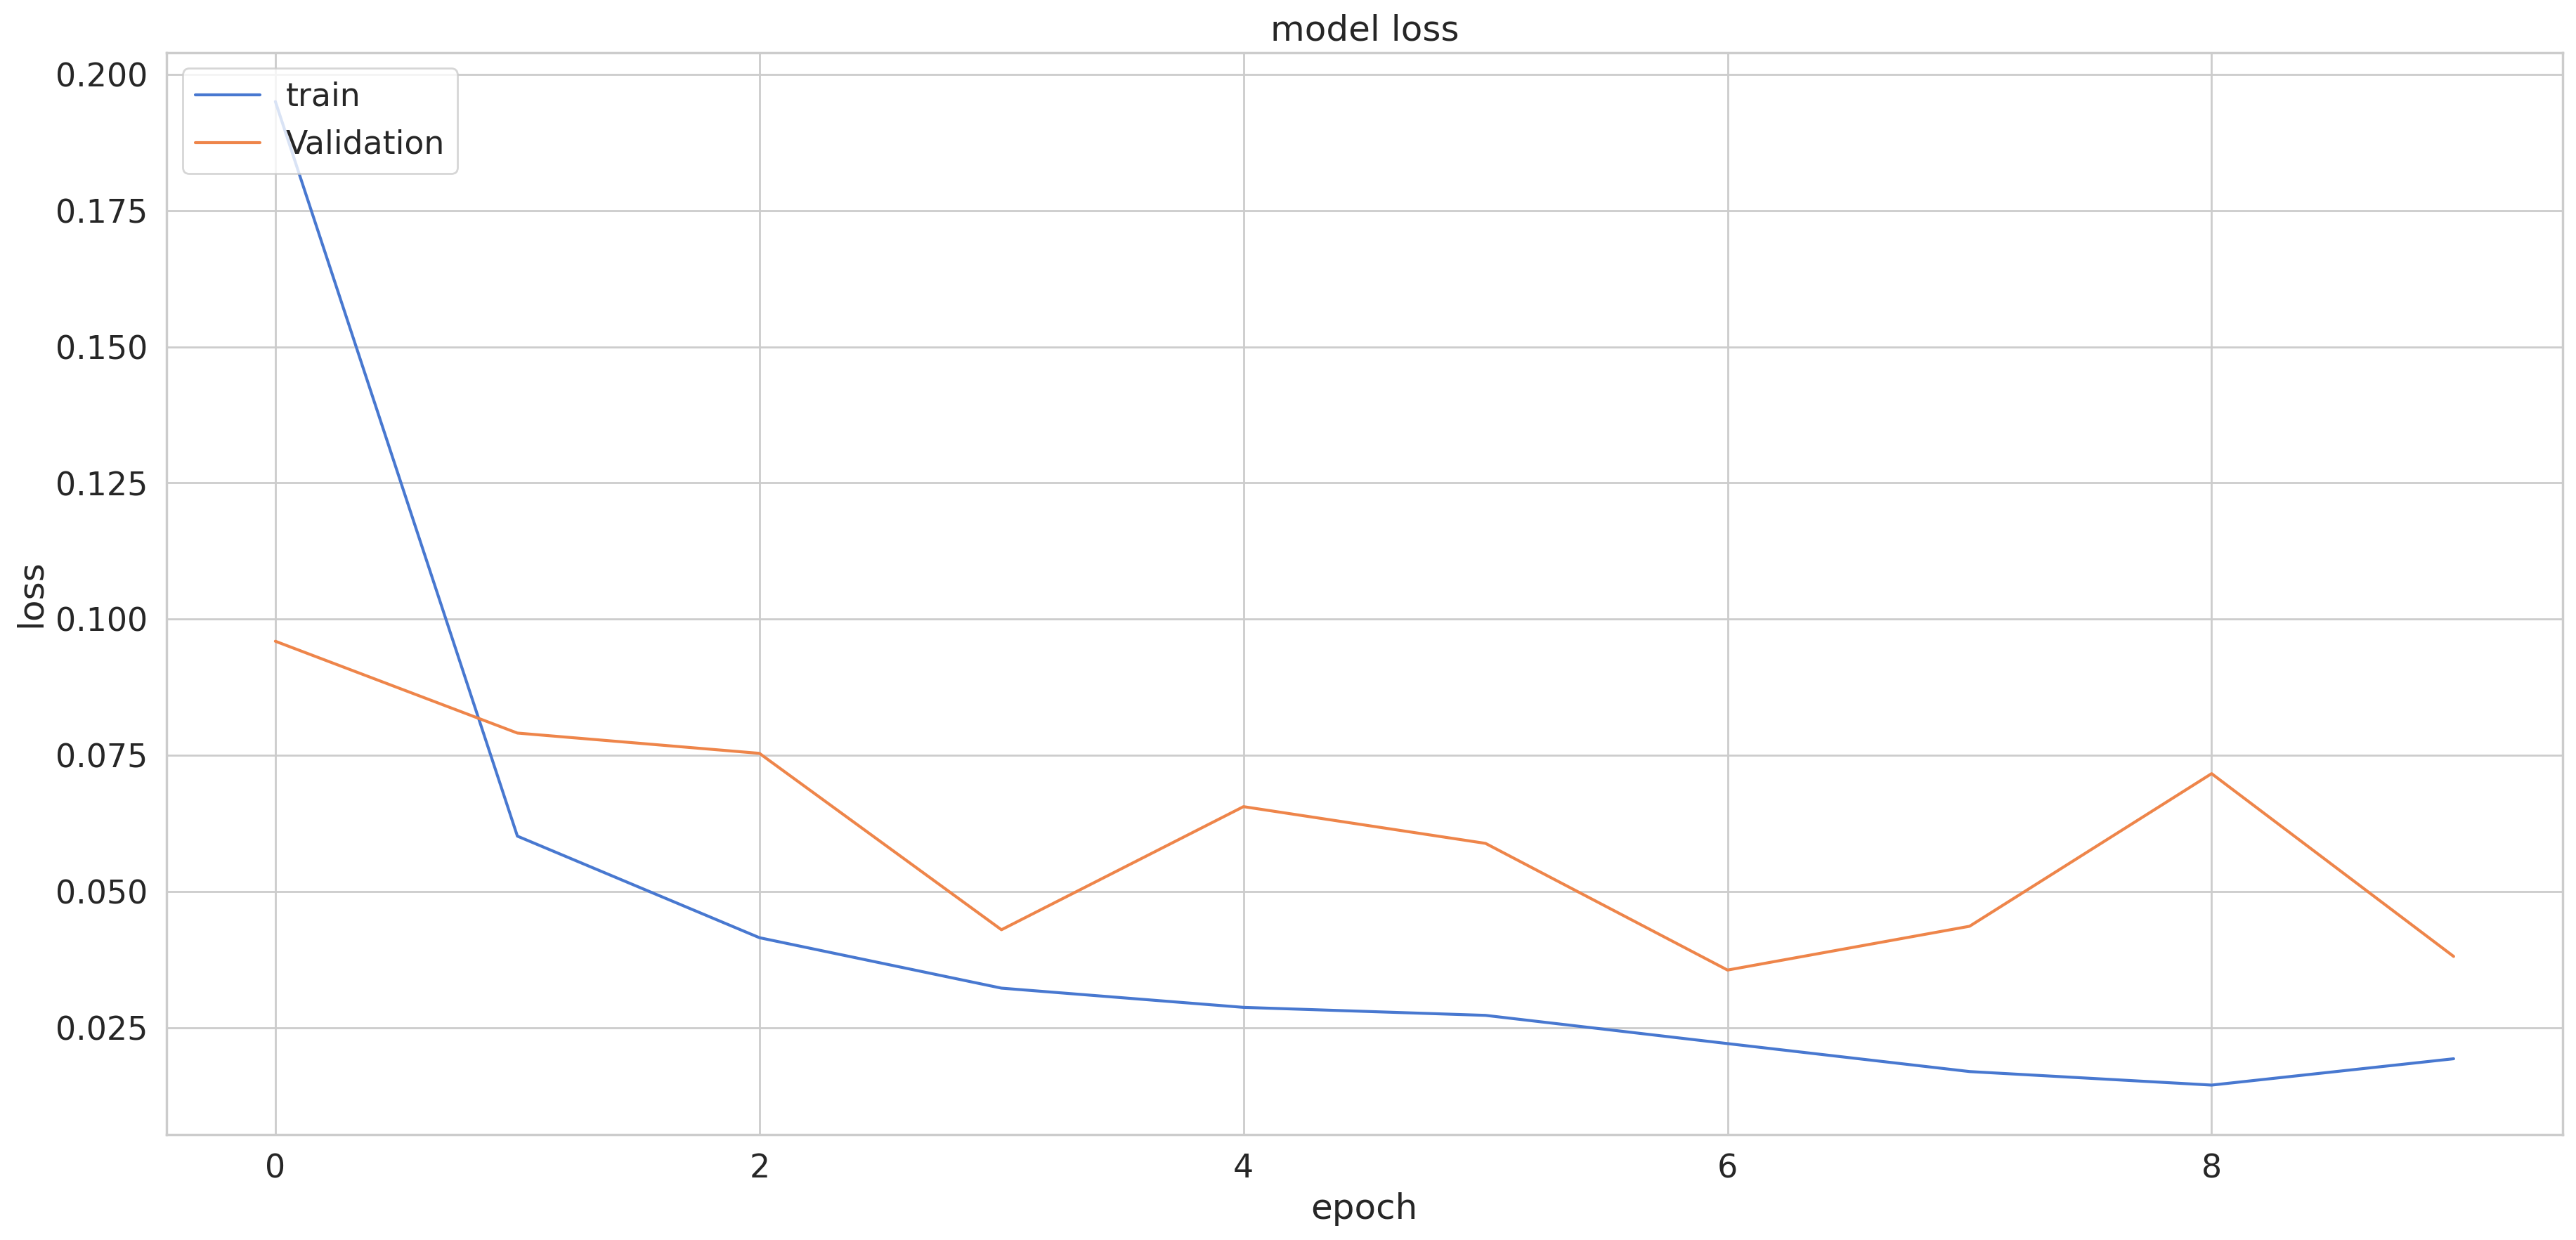

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

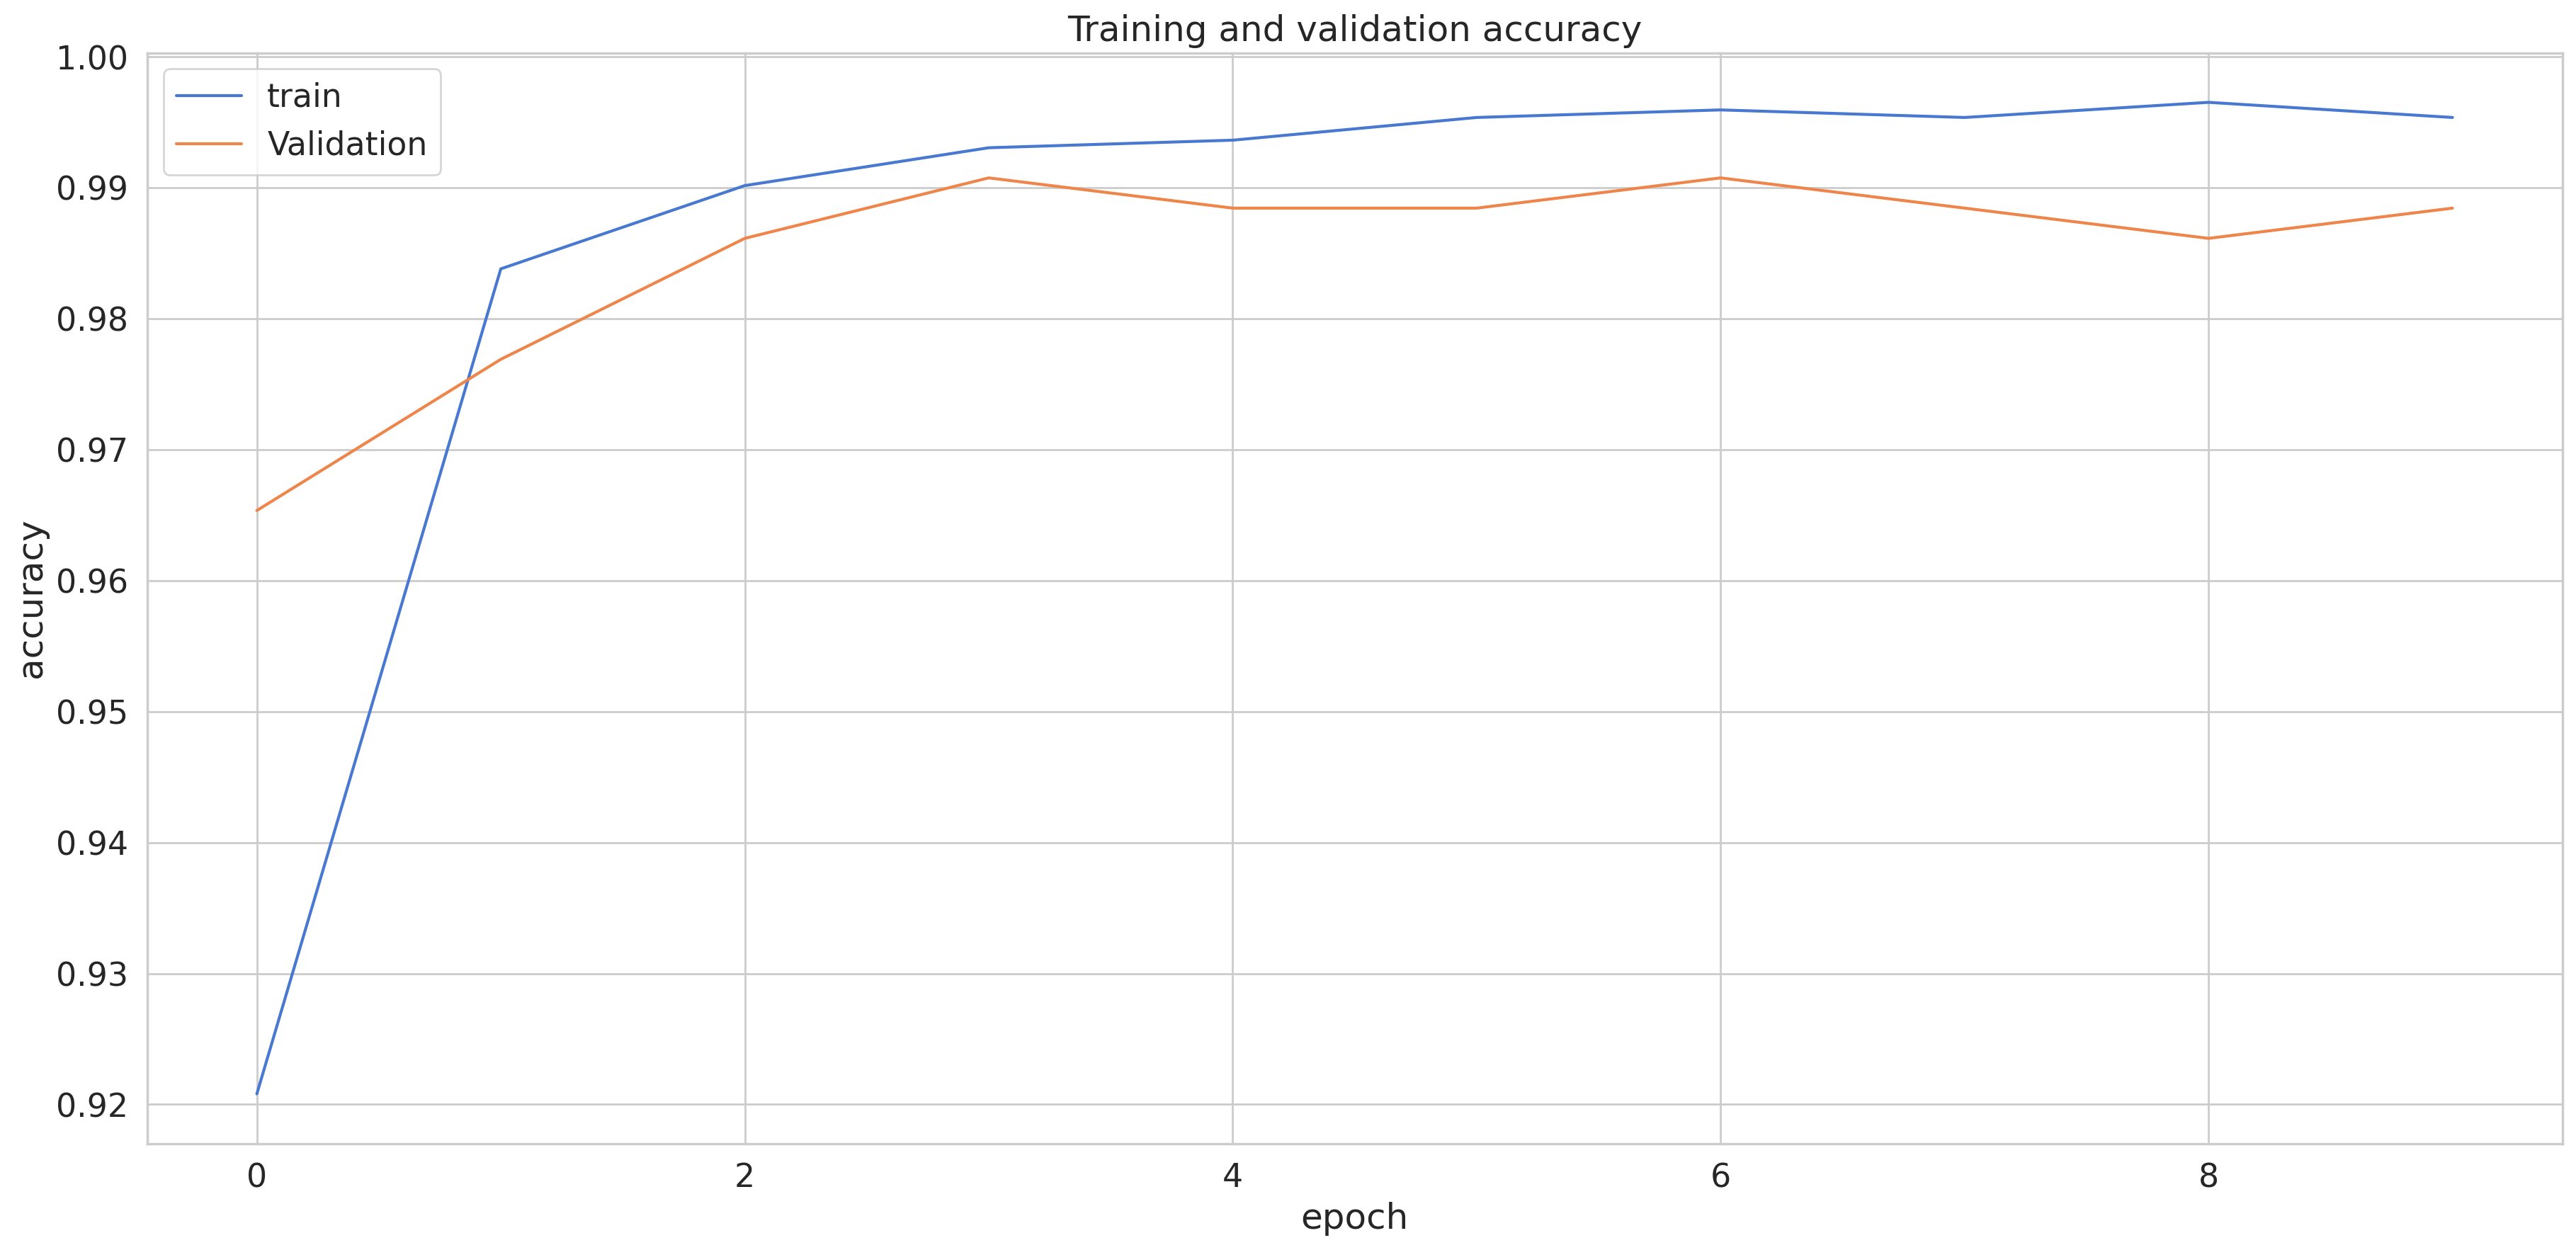

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

17/17 [==============================] - 0s 15ms/step
f1_score =  0.9889136387521597
0.988909426987061
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       299
           1       0.98      0.99      0.99       242

    accuracy                           0.99       541
   macro avg       0.99      0.99      0.99       541
weighted avg       0.99      0.99      0.99       541



<Axes: >

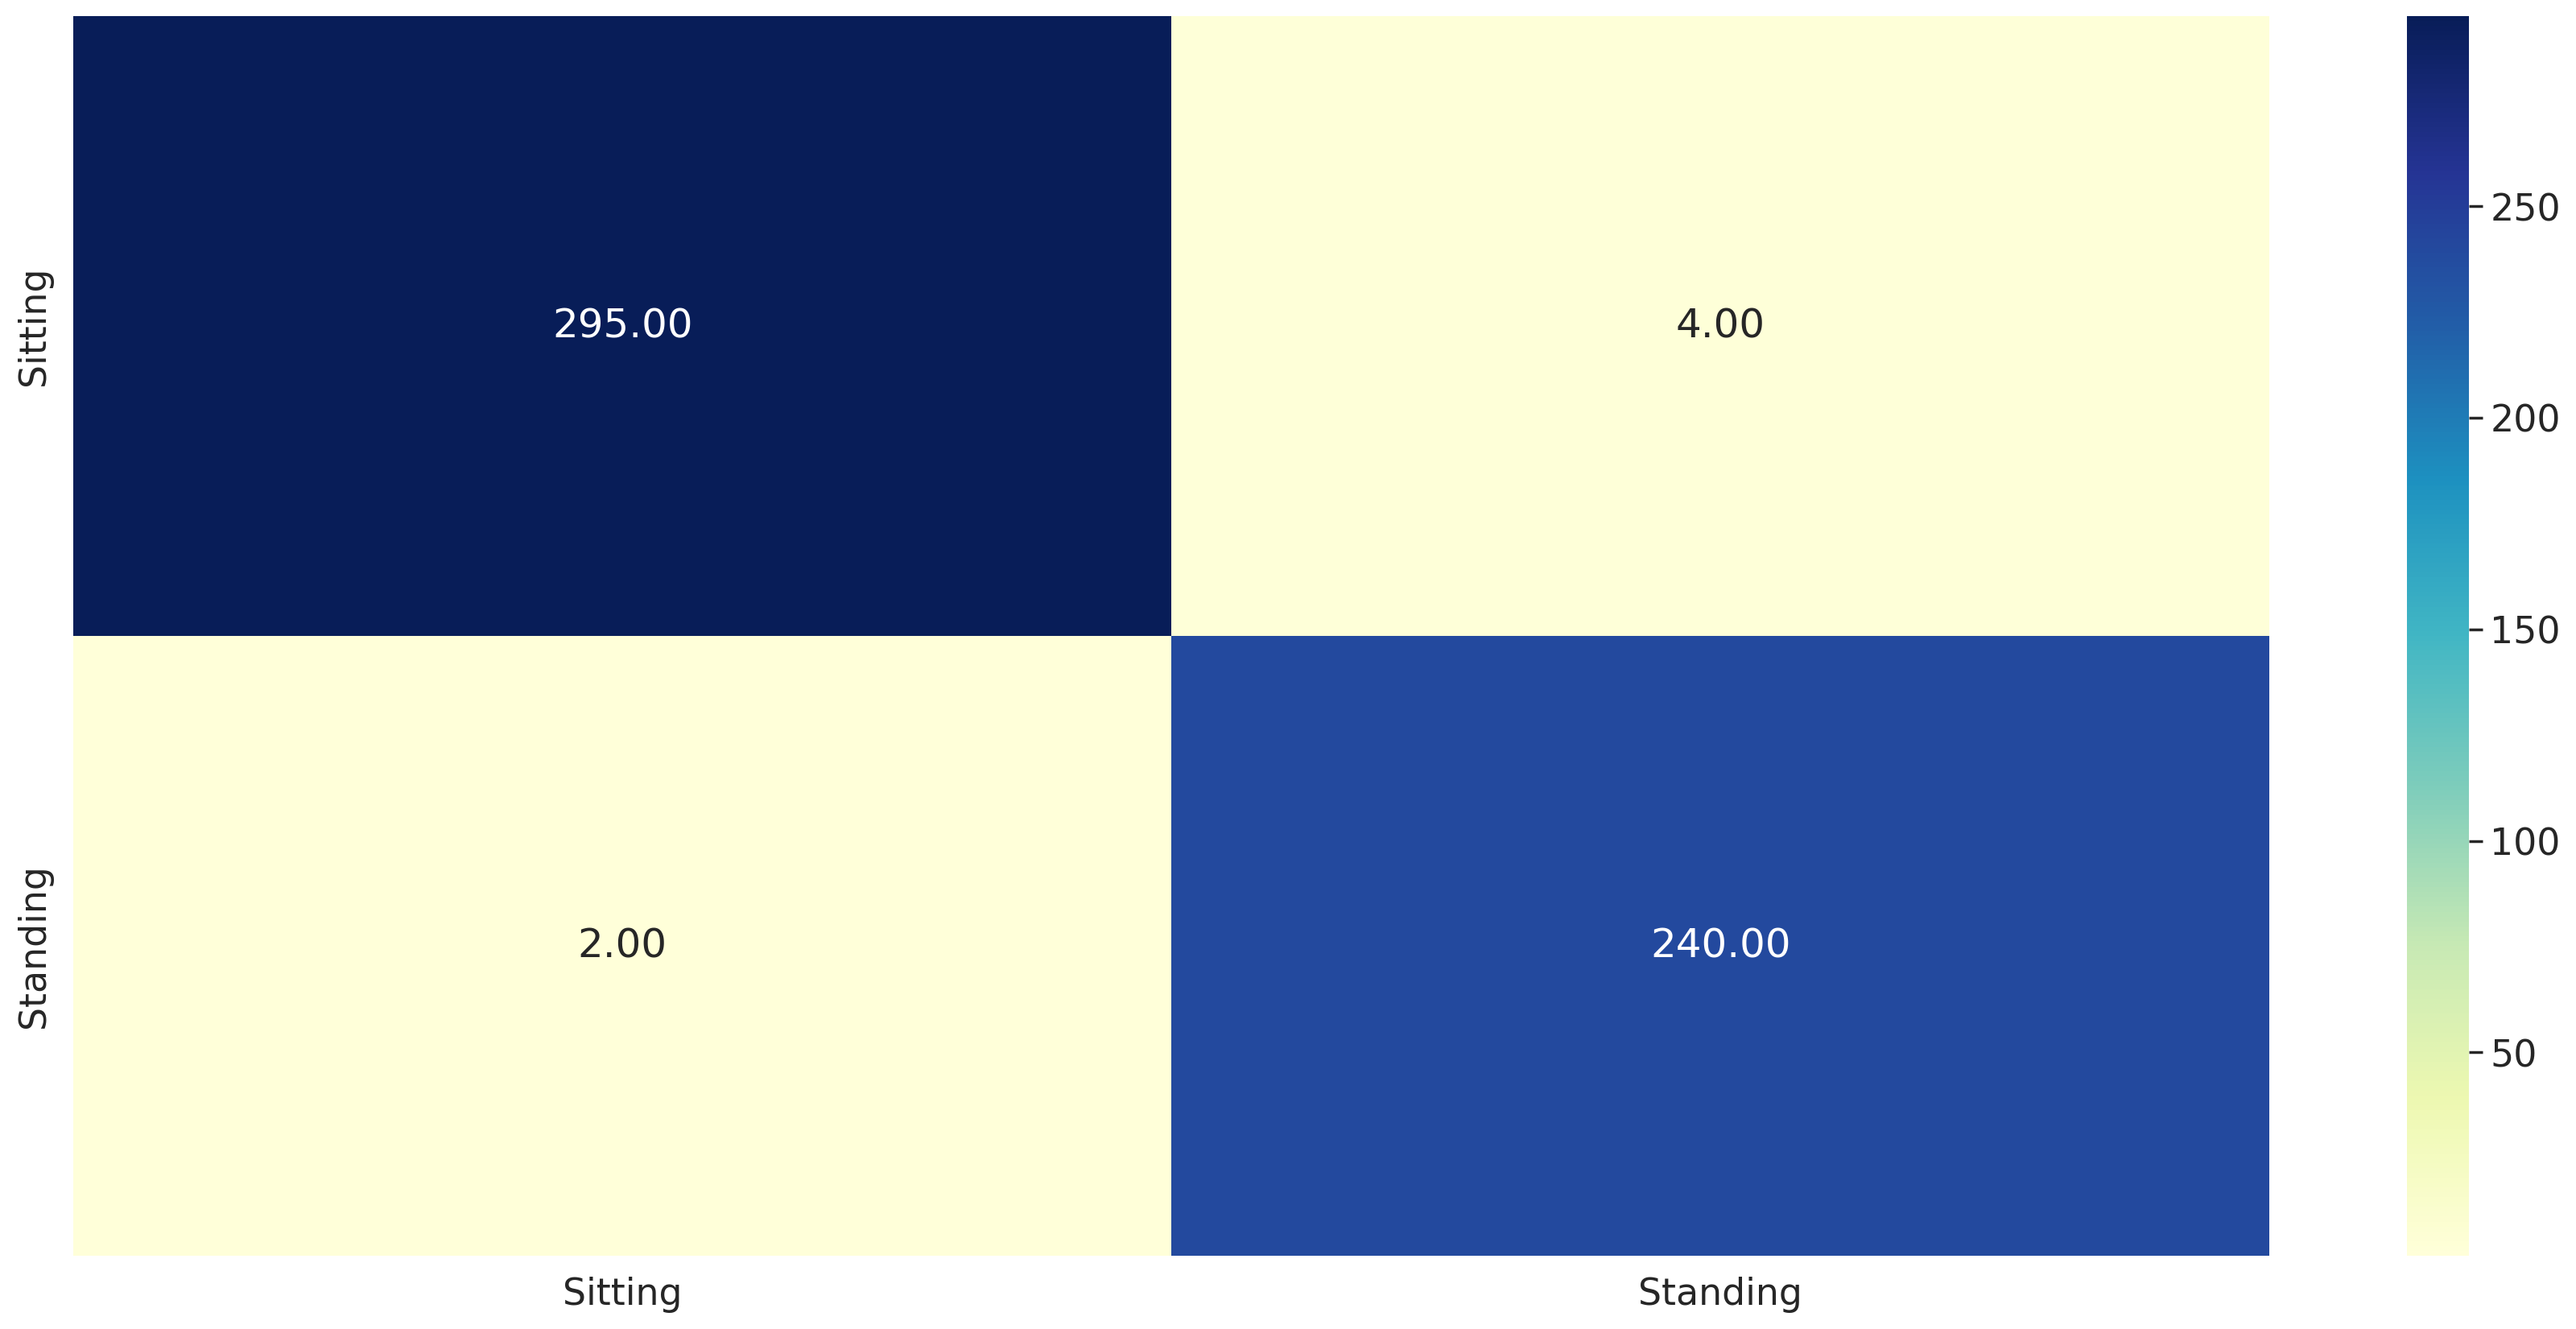

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN5

In [16]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 198, 64)           640       
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 64)           12352     
                                                                 
 conv1d_2 (Conv1D)           (None, 194, 64)           12352     
                                                                 
 conv1d_3 (Conv1D)           (None, 192, 64)           12352     
                                                                 
 conv1d_4 (Conv1D)           (None, 190, 64)           12352     
                                                                 
 flatten (Flatten)           (None, 12160)             0         
                                                                 
 dense (Dense)               (None, 128)               1

In [17]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
14/14 [==============================] - 5s 273ms/step - loss: 0.2429 - accuracy: 0.8792 - val_loss: 0.1074 - val_accuracy: 0.9700
Epoch 2/10
14/14 [==============================] - 4s 289ms/step - loss: 0.1163 - accuracy: 0.9636 - val_loss: 0.0846 - val_accuracy: 0.9723
Epoch 3/10
14/14 [==============================] - 5s 363ms/step - loss: 0.0750 - accuracy: 0.9740 - val_loss: 0.1001 - val_accuracy: 0.9630
Epoch 4/10
14/14 [==============================] - 3s 236ms/step - loss: 0.0616 - accuracy: 0.9832 - val_loss: 0.0599 - val_accuracy: 0.9885
Epoch 5/10
14/14 [==============================] - 3s 230ms/step - loss: 0.0394 - accuracy: 0.9908 - val_loss: 0.0521 - val_accuracy: 0.9885
Epoch 6/10
14/14 [==============================] - 3s 227ms/step - loss: 0.0293 - accuracy: 0.9942 - val_loss: 0.0407 - val_accuracy: 0.9908
Epoch 7/10
14/14 [==============================] - 5s 398ms/step - loss: 0.0321 - accuracy: 0.9936 - val_loss: 0.0425 - val_accuracy: 0.9908
Epoch 

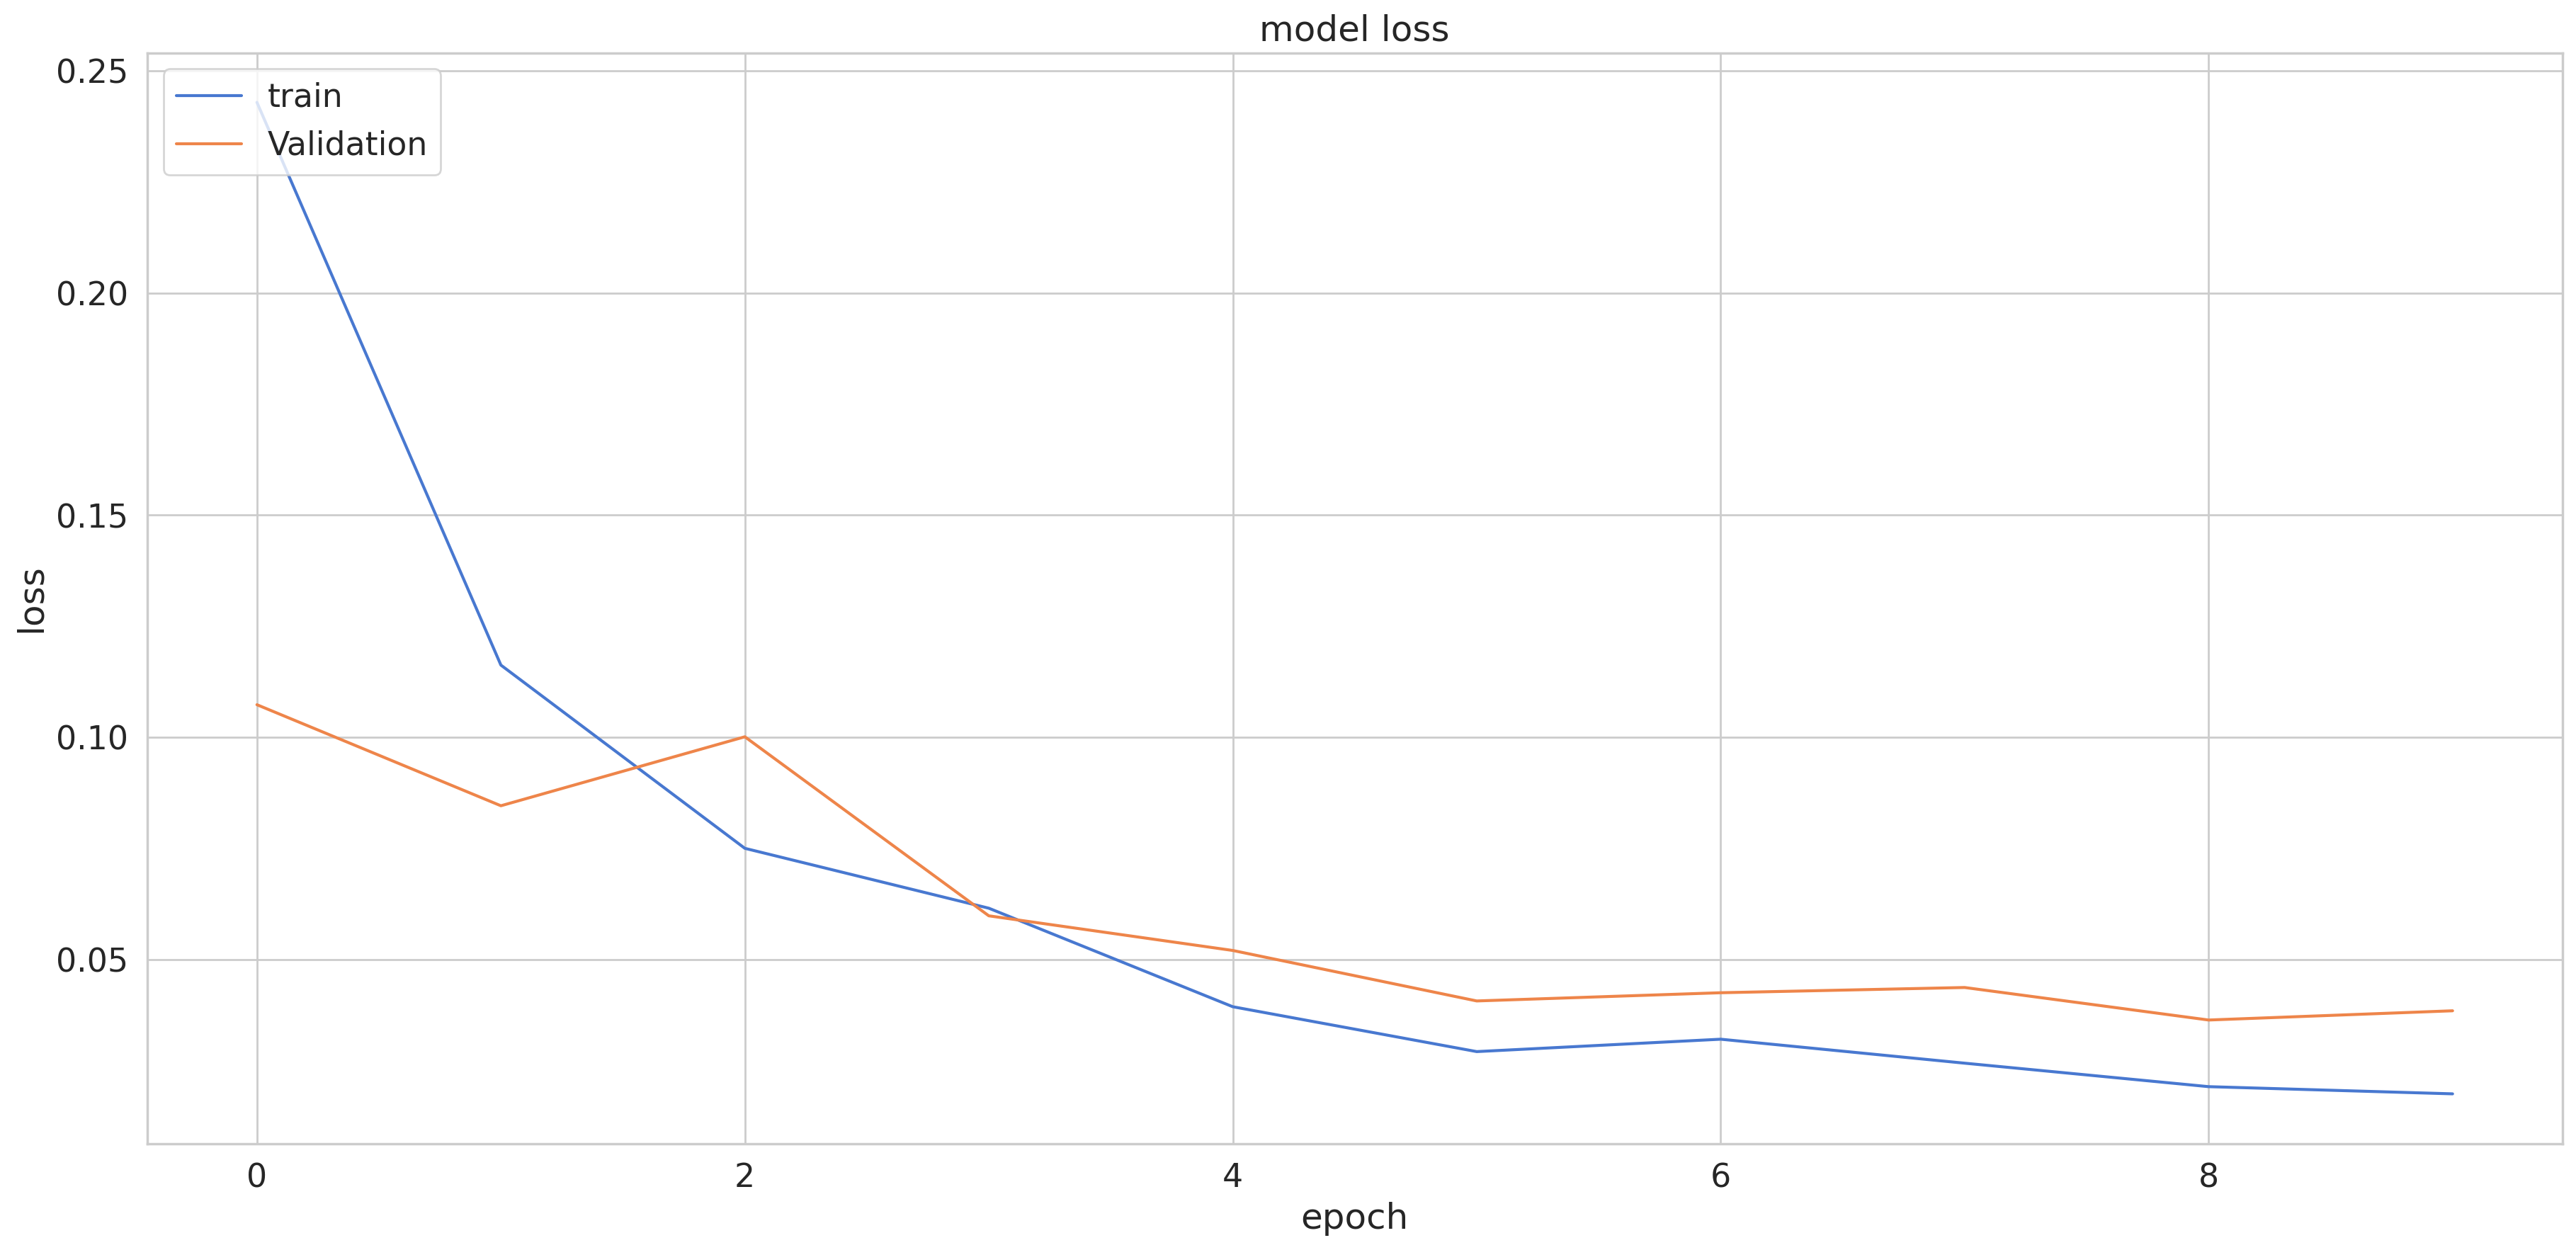

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

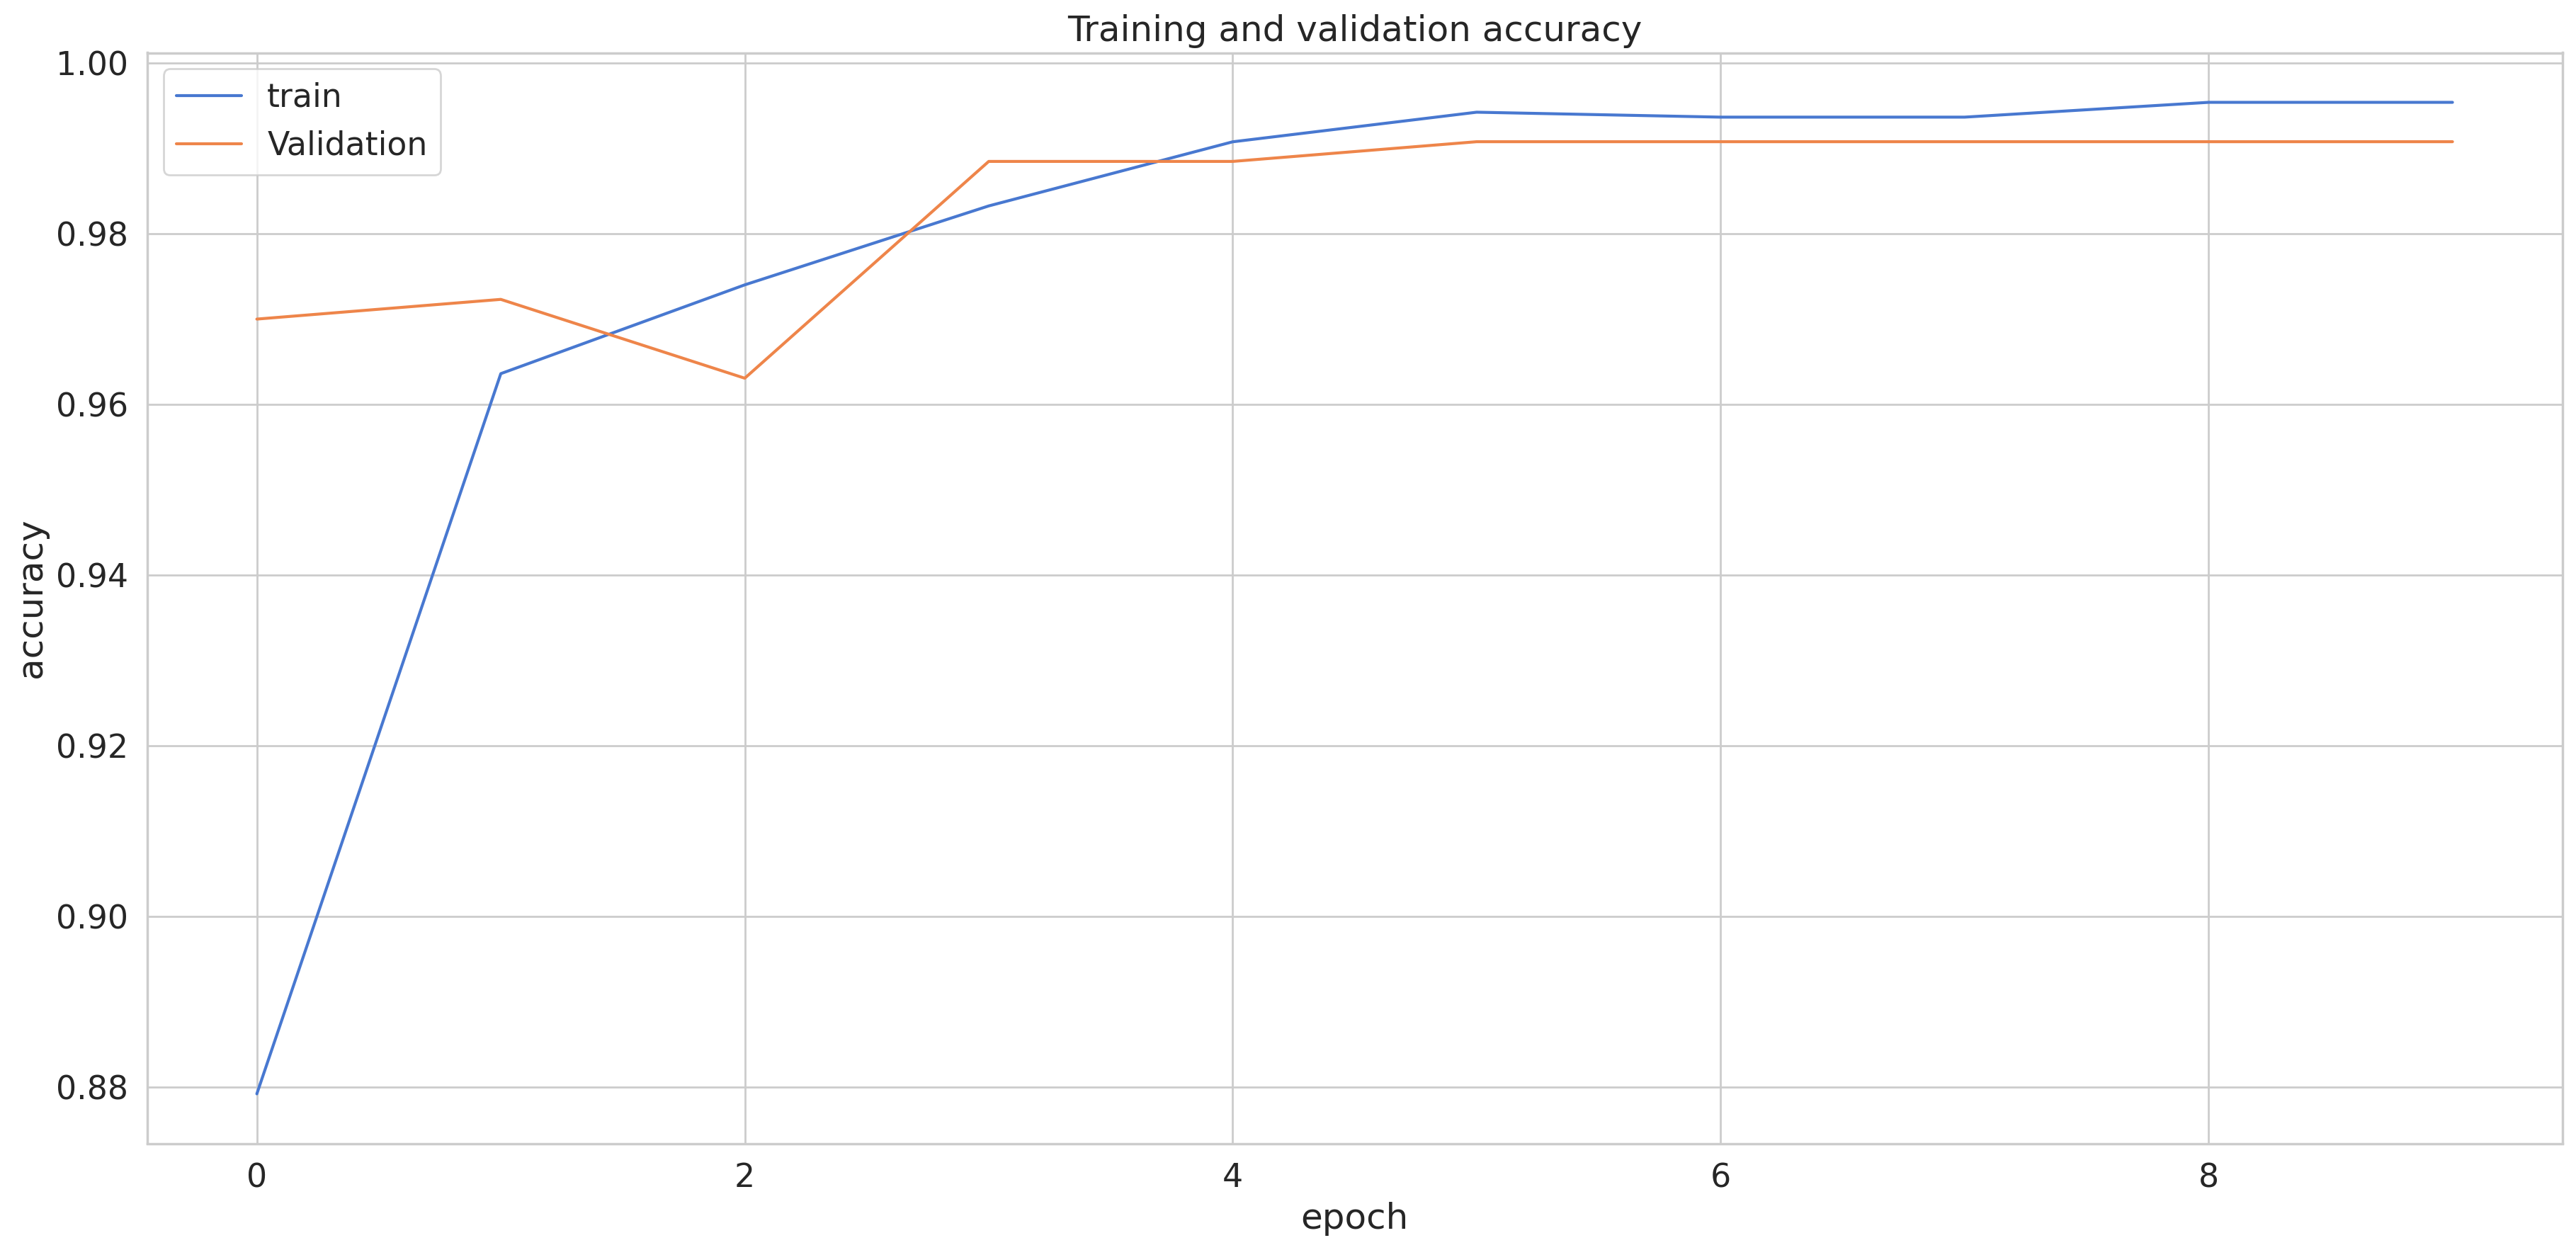

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

17/17 [==============================] - 0s 19ms/step
f1_score =  0.9963031423290203
0.9963031423290203
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       299
           1       1.00      1.00      1.00       242

    accuracy                           1.00       541
   macro avg       1.00      1.00      1.00       541
weighted avg       1.00      1.00      1.00       541



<Axes: >

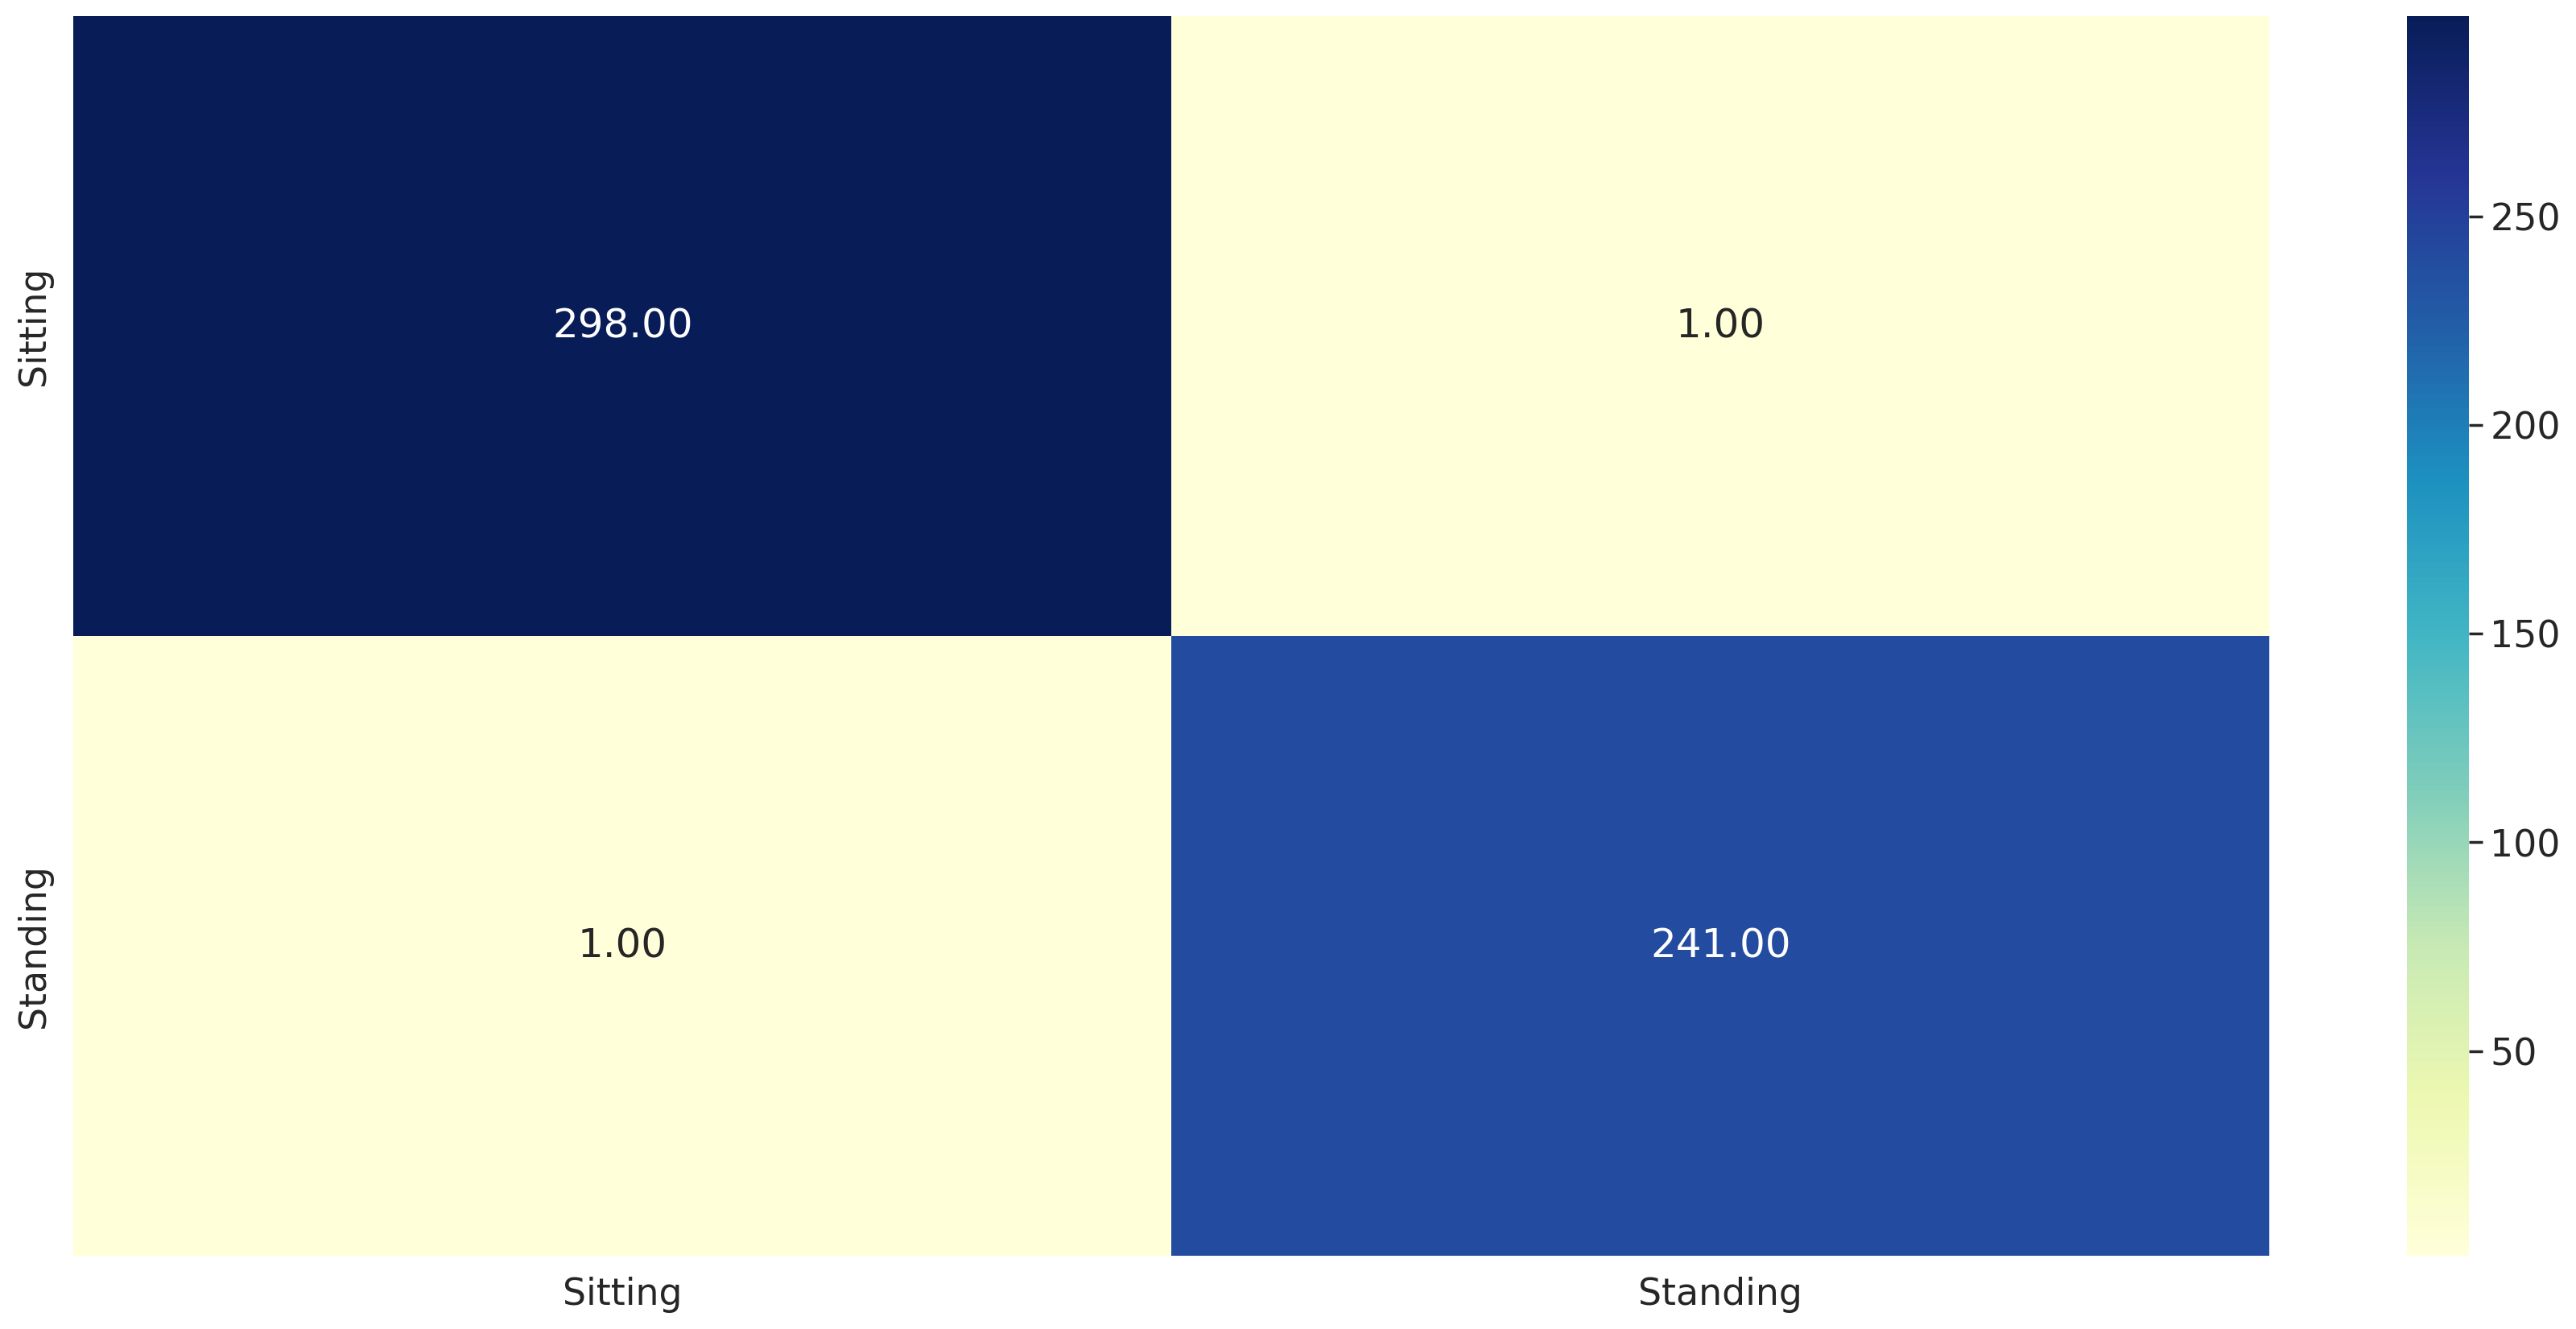

In [20]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')